# KBMOD Search for Multi-Night Results
  
A basic notebook to demonstrate searching results that appear across multiple nights.

Note that this notebook is intended to be run using shared data on baldur.

# Setup demo

Before importing, make sure you have installed kbmod using `pip install .` in the root `KBMOD` directory.  Also be sure you are running with python3 and using the correct notebook kernel.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os

import kbmod
from kbmod.analysis.plotting import *
from kbmod.data_interface import load_deccam_layered_image
from kbmod.search import ImageStack, PSF, StampCreator, Trajectory
from kbmod.results import Results
from kbmod.work_unit import WorkUnit
from kbmod.trajectory_generator import VelocityGridSearch
from kbmod.trajectory_utils import trajectory_predict_skypos

from kbmod.trajectory_explorer import TrajectoryExplorer

from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u
from astropy.table import Table
import astropy.time 

In [2]:
# Data paths
wu_path = "/epyc/projects/kbmod/runs/wbeebe/20240609_42au/slice0/reprojected_wu.fits"  # A reflex-corrected WorkUnit
res_path = "/epyc/projects/kbmod/runs/wbeebe/20240609_42au/slice0"

# Path to known fakes (with reflex-corrected) coordinates on the dates used in this KBMOD search.
fakes_path = "/epyc/projects/kbmod/runs/wbeebe/fakes_42_au_2019_04_02_and_2019_05_07.csv"

# Reload a Saved KBMOD WorkUnit
Note that this WorkUnit was reflex-corrected with a guess distance of 42 AU.

By reloading the WorkUnit, we're able to recreate the stamps for individual observations in any given trajectory

In [3]:
wu = WorkUnit.from_fits(wu_path)

stack = wu.im_stack

print(f"Loaded stack with {stack.img_count()} images")

Setting unknown parameter: cluster_function
Setting unknown parameter: num_cores


Loaded stack with 189 images


# Reload KBMOD Results

A KBMOD run will store several files in its results directory. But we can generate a `Results` object (which wraps an astropy Table) from the `results.ecsv`

In [4]:
results = Results.read_table(os.path.join(res_path, "results.ecsv"))
results

x,y,vx,vy,likelihood,flux,obs_count,psi_curve,phi_curve,obs_valid,stamp
int64,int64,float64,float64,float64,float64,int64,float64[189],float64[189],bool[189],"float32[21,21]"
2458,1457,-273.39910888671875,-167.07212829589844,548.1395256786241,3837.5597191102593,95,0.7581438422203064 .. 0.0,0.00021865294547751546 .. 0.0,True .. False,269.5005 .. 99.88307
1423,1454,-208.7044677734375,-271.6656188964844,492.54509203931417,13810.742881176542,96,0.2472669929265976 .. 0.0,1.178416823677253e-05 .. 0.0,True .. False,53909.777 .. 40012.61
1115,4462,-196.34774780273438,-67.20700073242188,506.3831594626593,5479.172218456264,100,-0.41006651520729065 .. 0.0,9.164521907223389e-05 .. 0.0,False .. False,8062.2617 .. -2031.9956
509,160,-297.7602233886719,-185.16937255859375,474.9591686214317,6115.399382147621,97,0.07043198496103287 .. 0.0,4.867810275754891e-05 .. 0.0,True .. False,6938.071 .. -9153.42
508,164,-292.9170227050781,-217.3526611328125,479.3770856693554,5846.413579340423,101,0.10707317292690277 .. 0.0,5.6429707910865545e-05 .. 0.0,True .. False,9429.096 .. -13768.495
507,168,-283.61956787109375,-245.06338500976562,462.31843103076113,5576.155516978887,101,0.11074761301279068 .. 0.0,6.3385879911948e-05 .. 0.0,True .. False,10104.895 .. -10364.641
3283,2692,-51.415260314941406,-17.59870147705078,409.36207340950784,2025.645503007611,103,0.5943410992622375 .. 0.0,0.00041448348201811314 .. 0.0,True .. False,-190.19298 .. -214.22815
4304,445,-263.5504150390625,-94.83505249023438,370.40708493857306,3027.979743054181,102,0.4169936180114746 .. 0.0,0.00016169525042641908 .. 0.0,True .. False,52.776375 .. -9891.322
508,191,-286.28369140625,-369.65081787109375,277.58137360143525,2930.225137282184,103,-0.1551782339811325 .. 0.0,0.0002252874110126868 .. 0.0,True .. False,8162.9937 .. -5242.371


Let's reconstruct the trajectories from our saved results and recreate the stamps for each observation

In [5]:
trajectories = results.make_trajectory_list()
results.table["all_stamps"] = [StampCreator.get_stamps(stack, trj, 10) for trj in trajectories]

Add a column to our results for the number of unique days observed for each result based on the MJDs 

In [6]:
def mjd_to_day(mjd):
    # Takes a float mjd and converts to a string calendar date
    return str(astropy.time.Time(mjd, format='mjd').to_value('datetime')).split()[0]

# For each result find the number of unique days observed.
num_days = []
for idx in range(len(results)):
    # Whether an observation was "valid" and included in the result
    is_valid = results[idx]["obs_valid"]
    
    # Get all of the observation times that were valid and included in the result
    valid_obstimes = [] 
    for i in range(len(is_valid)):
        if is_valid[i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    # Convert the obstimes to days and generate the number of days.
    num_days.append(len(set([mjd_to_day(t) for t in valid_obstimes])))

# Add as a column in the results table
results.table["num_days"] = num_days

Now for each result, we're interested in plotting the cumulative coadd as well as the coadds consisting only of the observations within a given day for that result.

In [7]:
# Generate coadds per each day to sanity check against the fakes.
def plot_daily_coadds(result_table, result_idx):
    # Map each day for a result to its coadded stamp
    daily_coadds = {}
    result_row = result_table[result_idx]
    for i in range(stack.img_count()):
        if result_row["obs_valid"][i]:
            day = mjd_to_day(stack.get_obstime(i))
            curr_stamp = result_row["all_stamps"][i]
            # Depending on where "all_stamps" is generated may be a RawImage
            if not isinstance(curr_stamp, np.ndarray):
                curr_stamp = curr_stamp.image

            if day not in daily_coadds:
                # Create the initial coadd
                daily_coadds[day] = curr_stamp.copy()
            else:
                # Add the stamps together
                daily_coadds[day] += curr_stamp
    
    # First we'll plot the full coadd
    imgs = [result_table["stamp"][result_idx]]
    labels = [f'Coadd for result {result_idx}']
    
    # Add images and labels for each individual day
    for day in daily_coadds:
        imgs.append(daily_coadds[day])
        labels.append(str(day))
    
    plot_multiple_images(imgs, labels=labels)

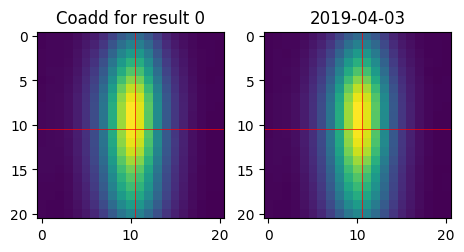

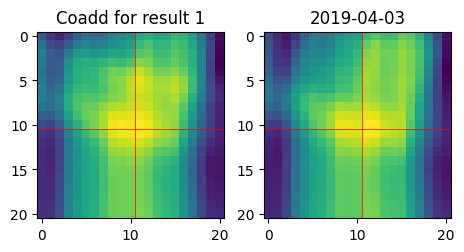

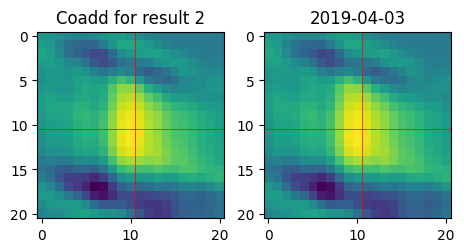

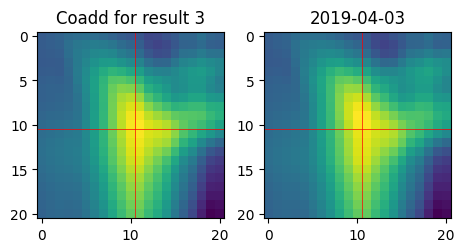

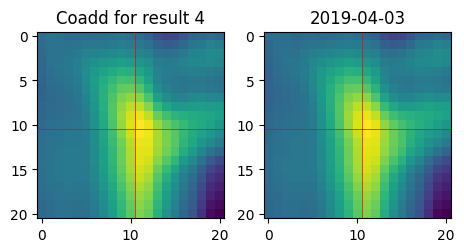

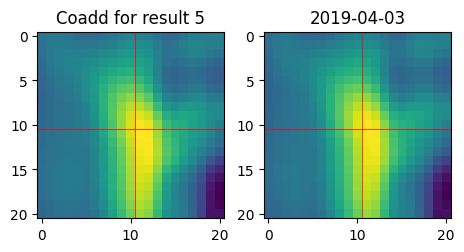

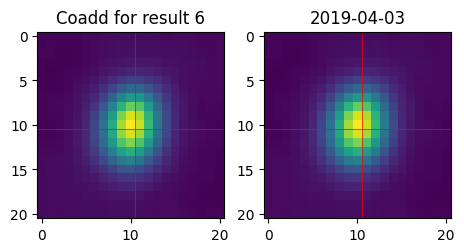

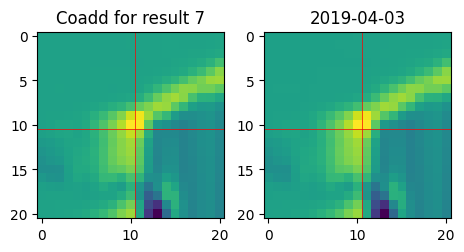

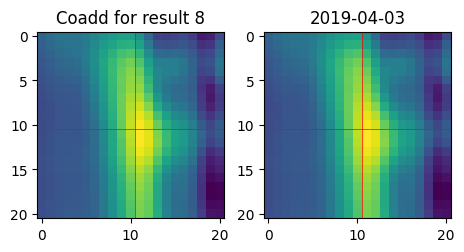

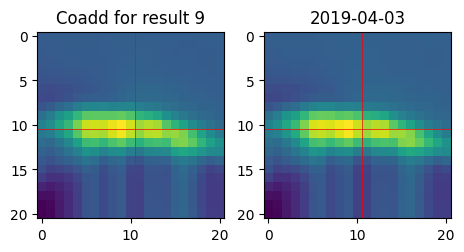

In [8]:
for i in range(min(len(results),10)):
    plot_daily_coadds(results, i)

/astro/users/wbeebe/.conda/envs/kbmod_new_wu/lib/python3.12/site-packages/kbmod/analysis/plotting.py:448: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(layout="constrained")


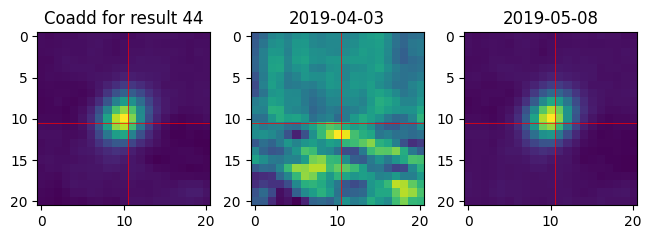

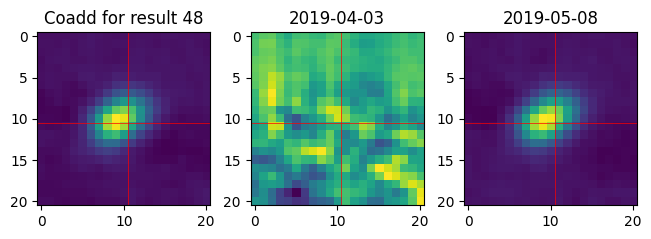

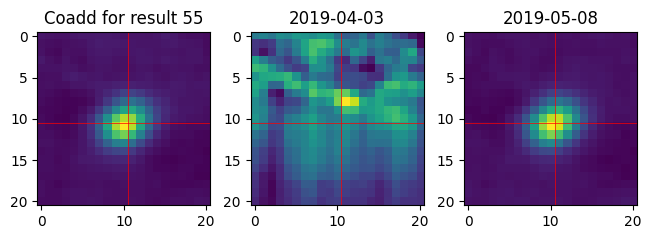

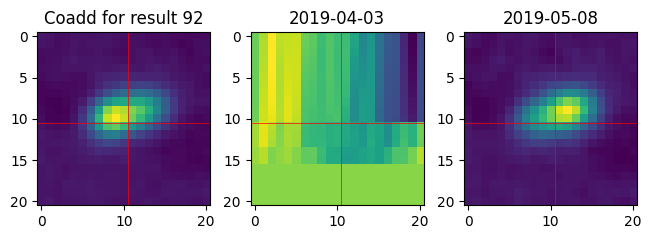

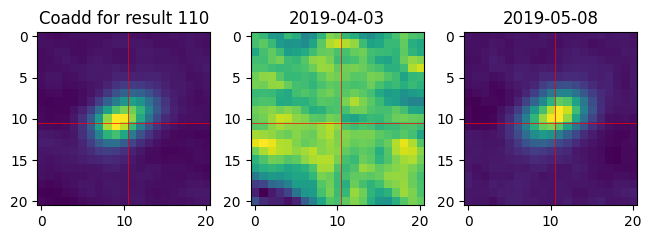

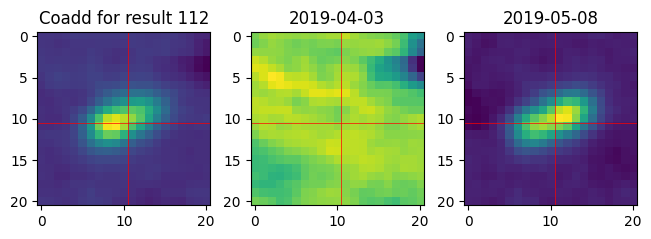

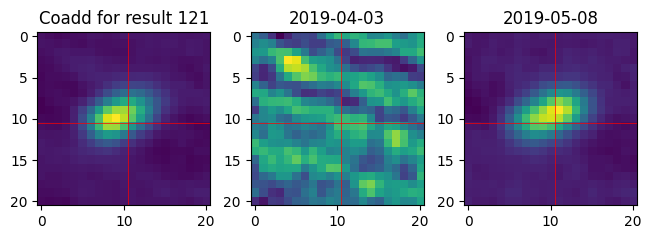

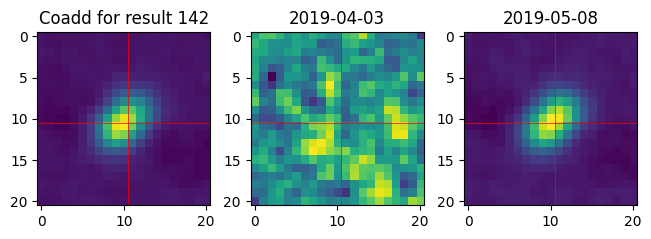

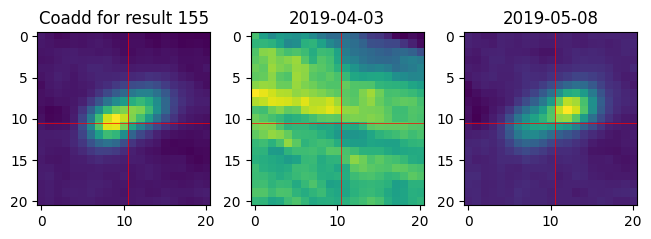

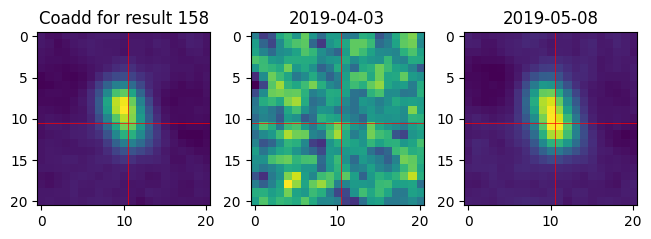

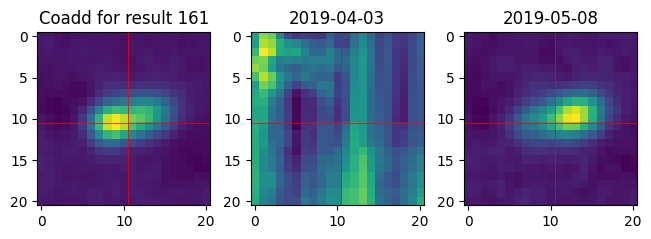

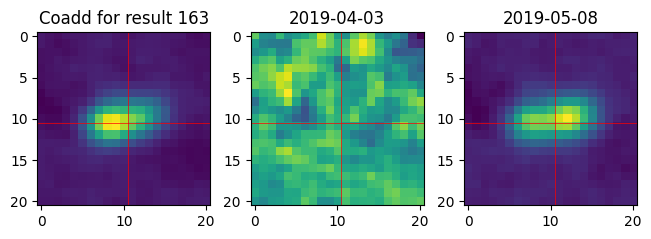

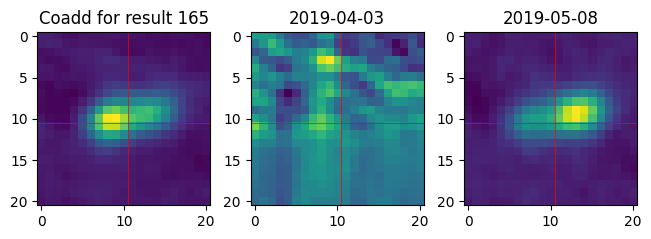

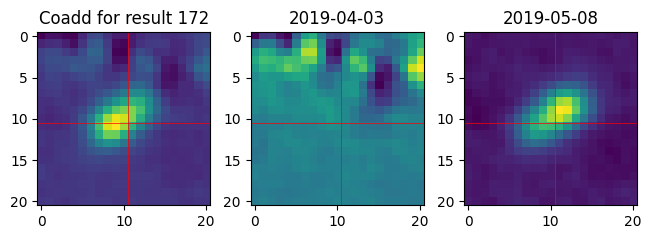

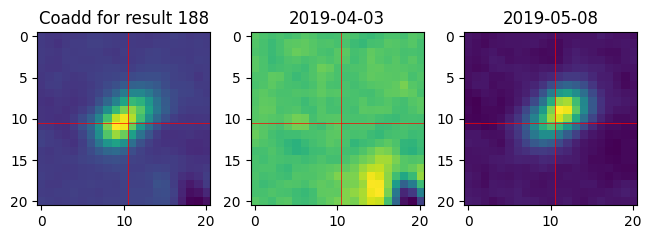

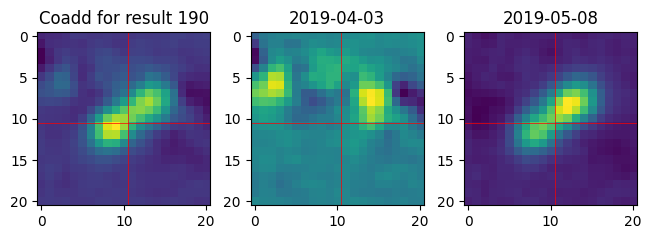

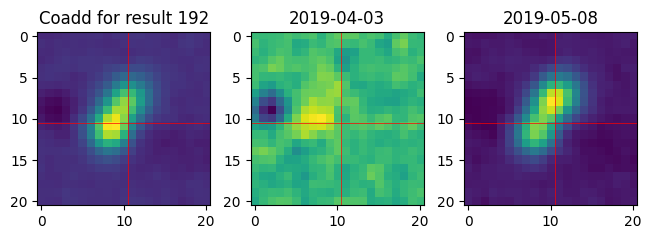

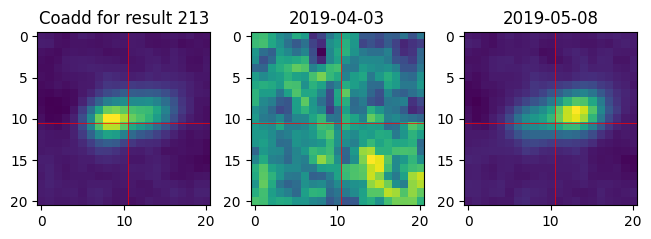

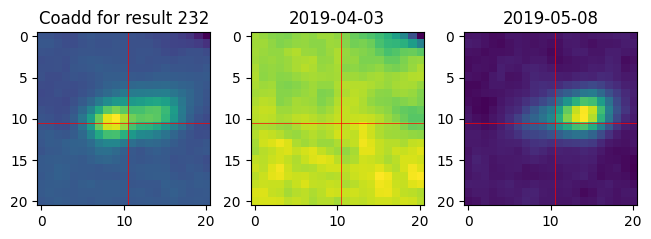

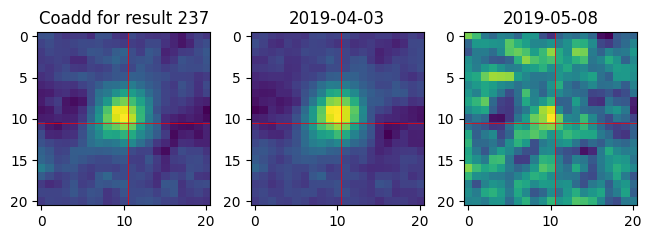

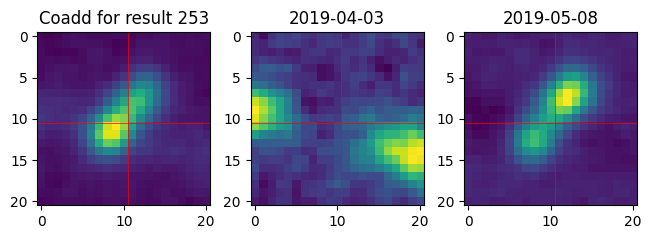

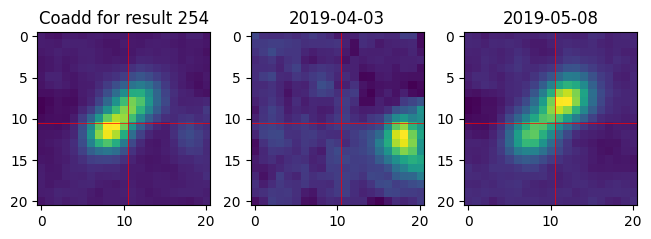

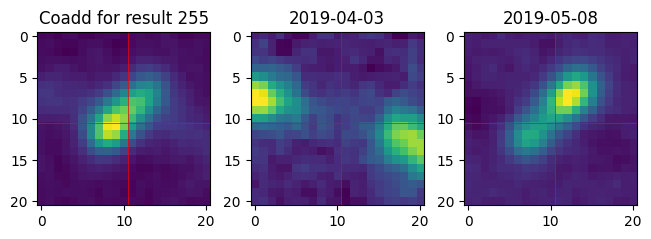

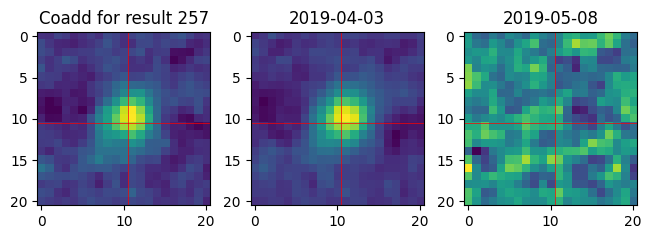

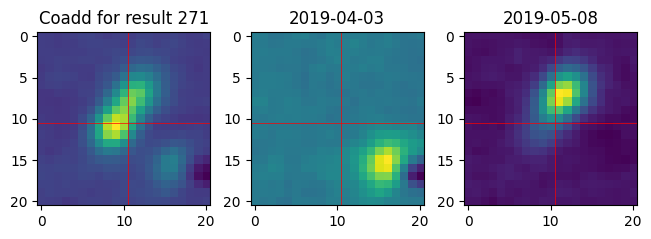

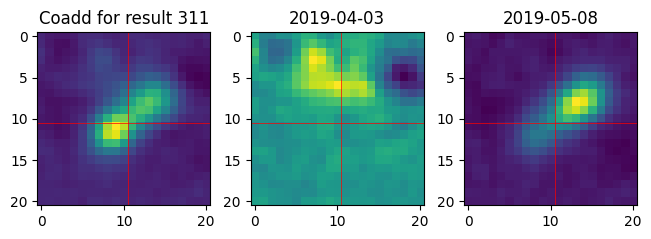

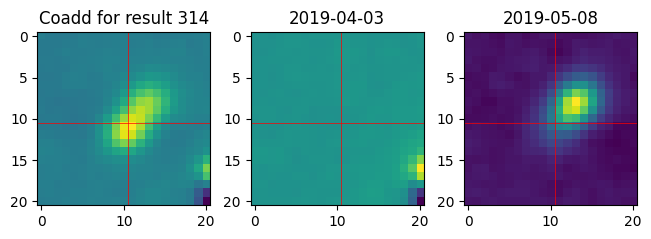

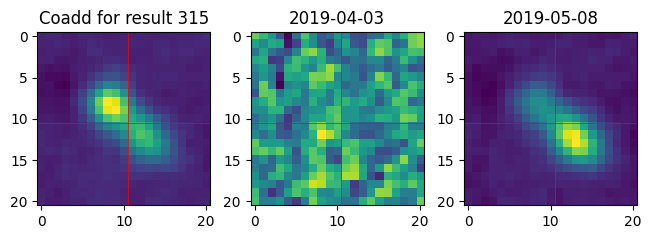

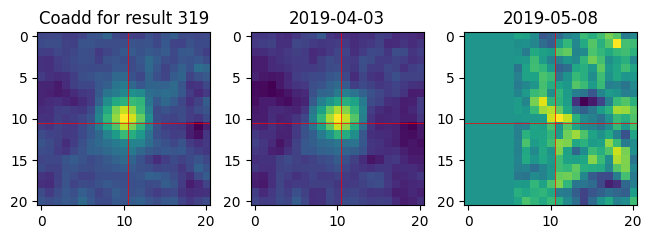

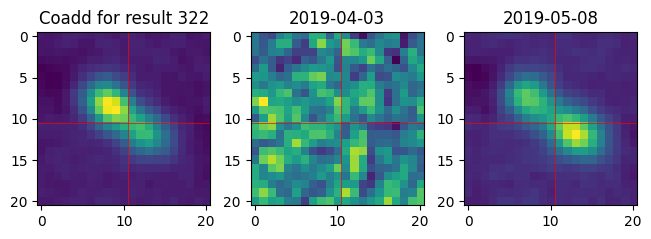

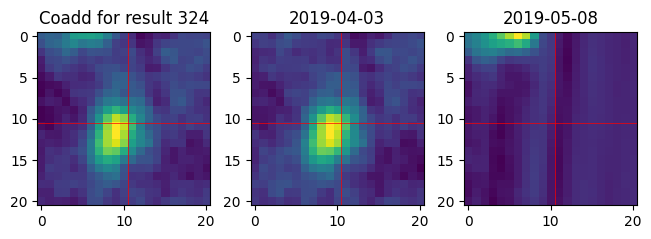

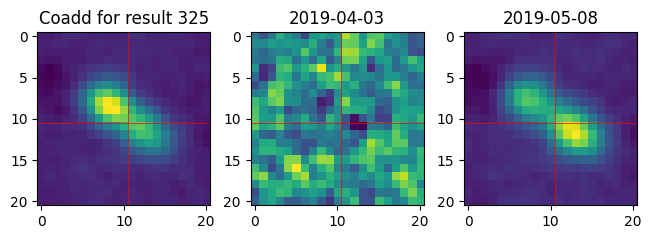

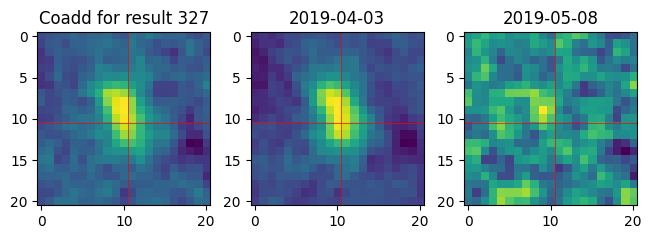

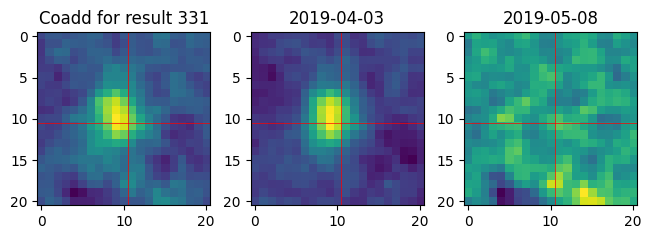

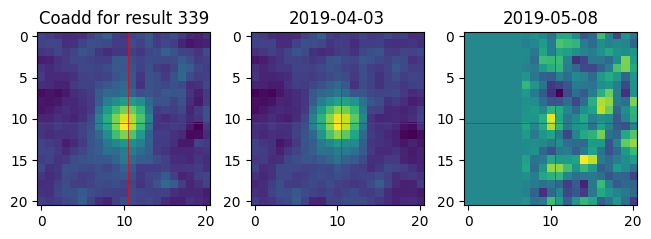

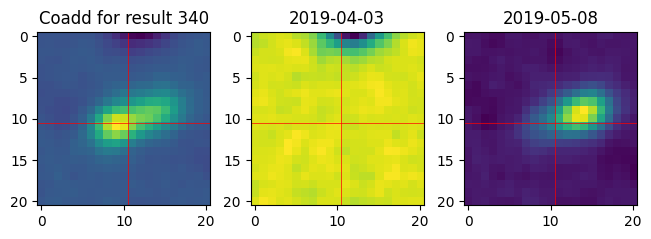

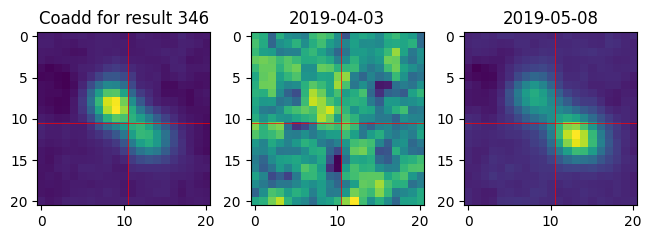

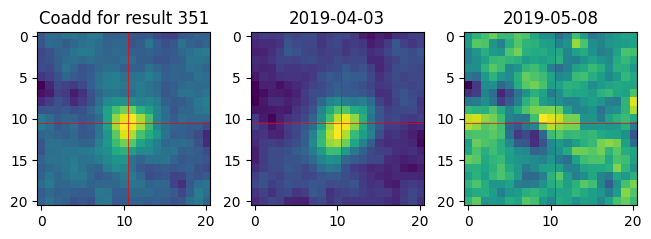

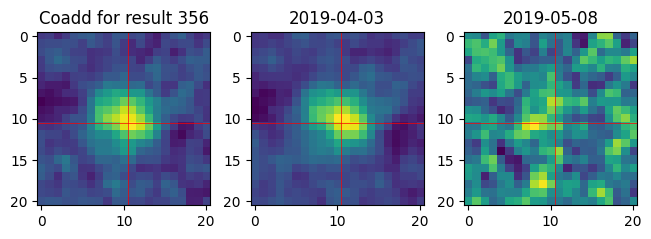

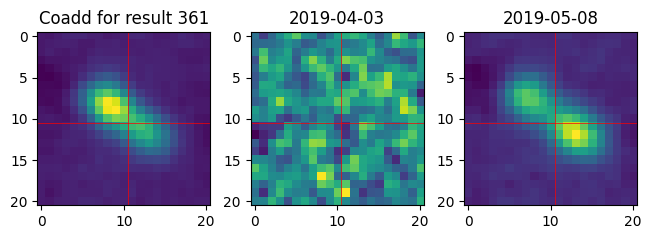

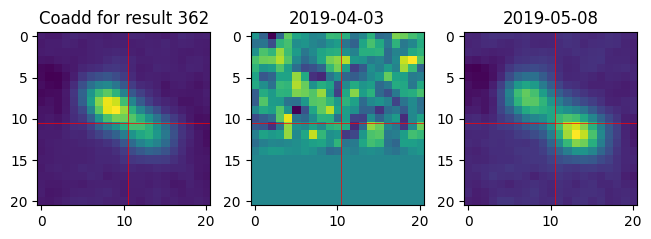

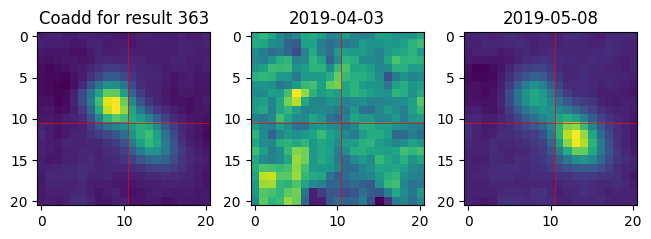

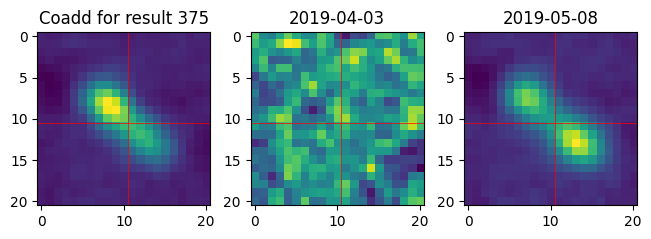

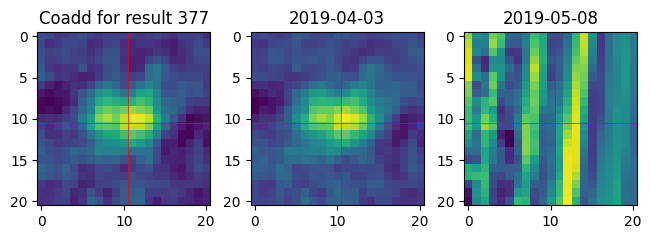

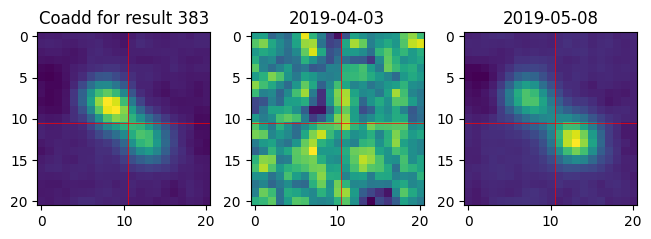

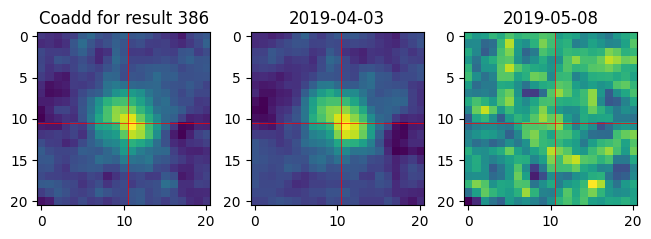

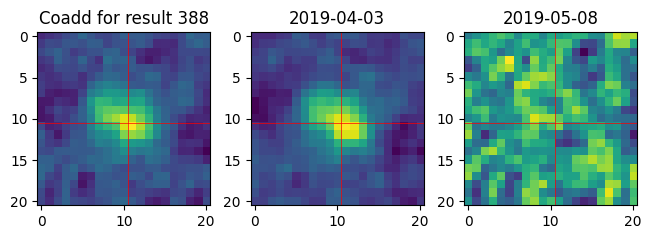

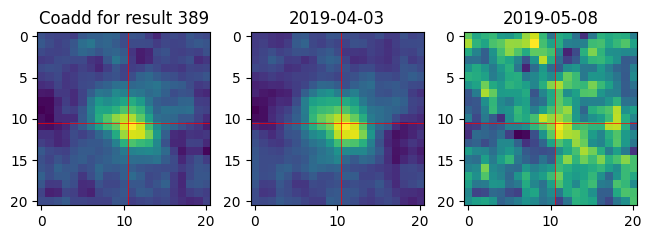

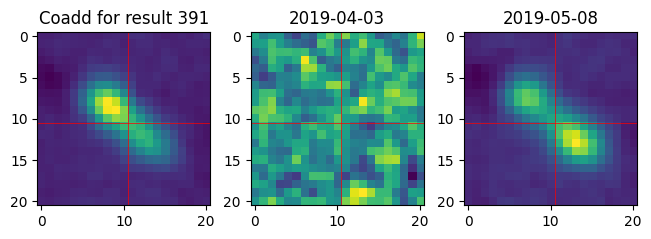

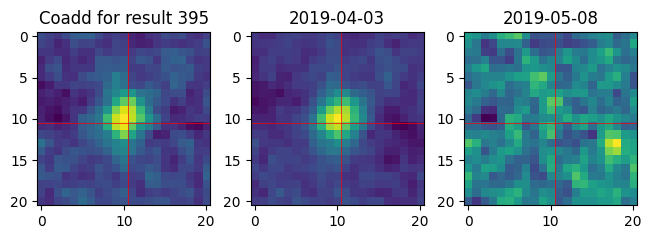

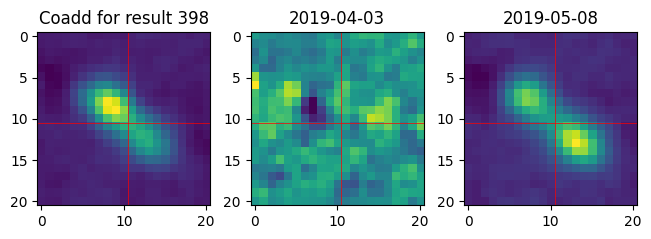

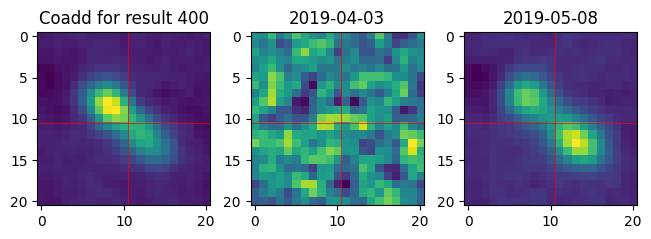

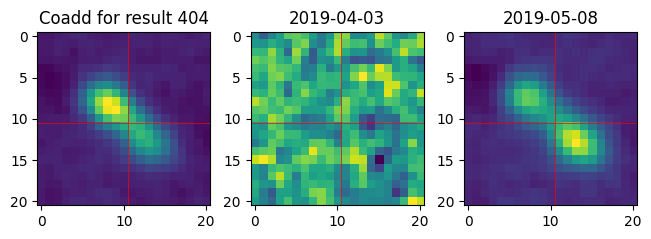

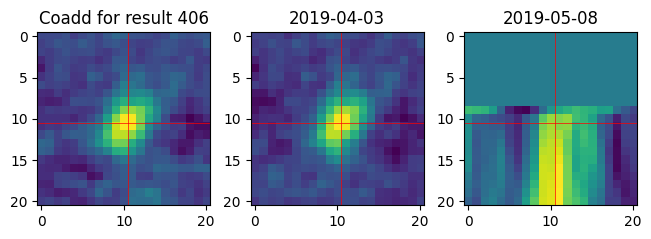

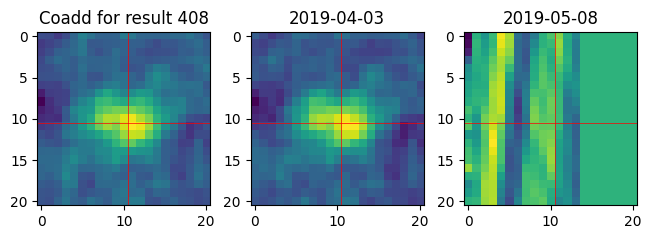

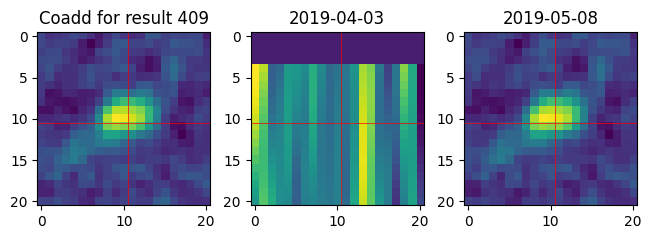

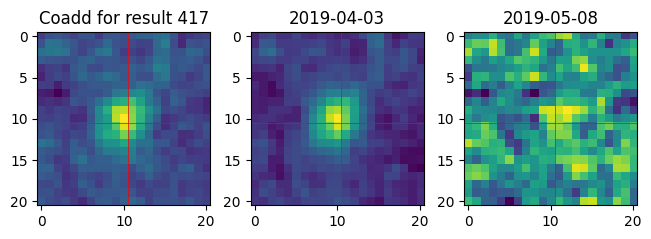

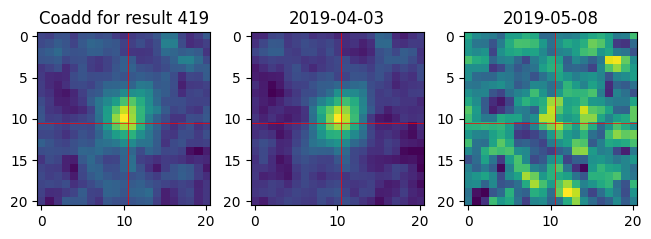

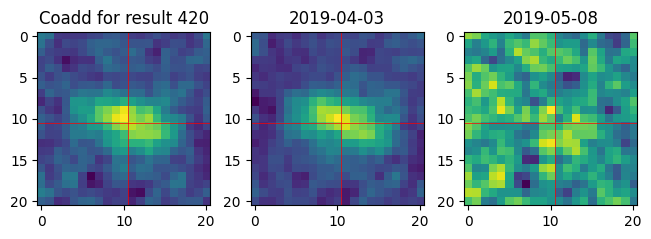

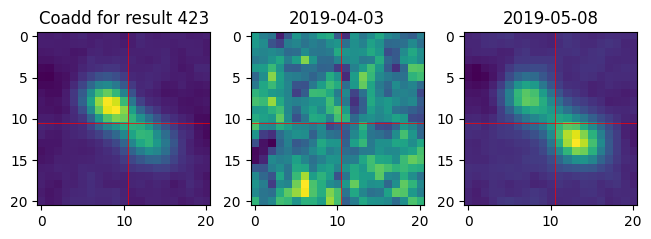

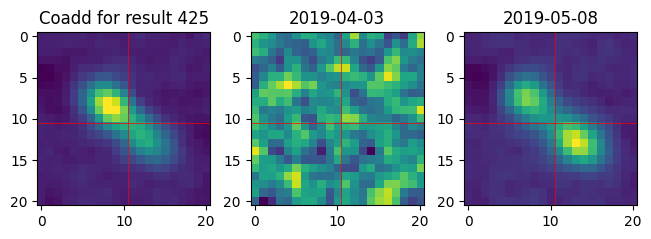

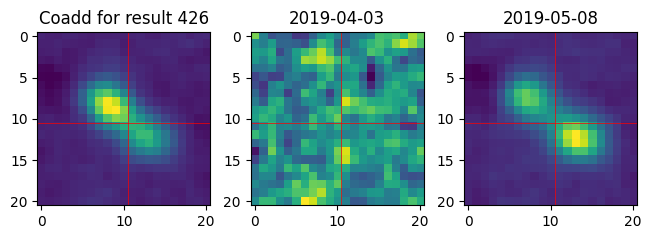

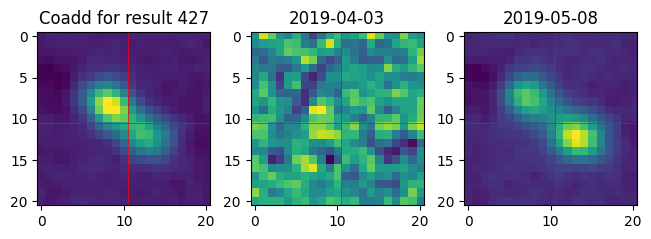

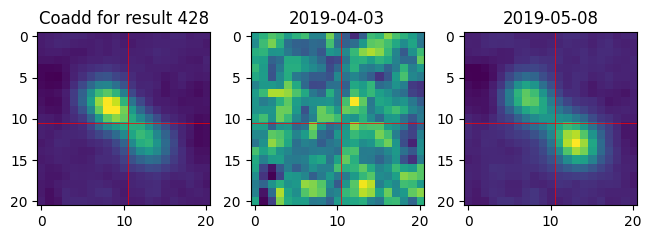

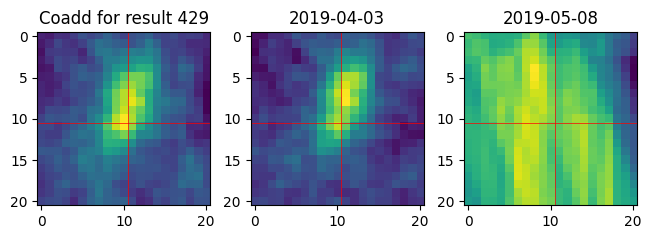

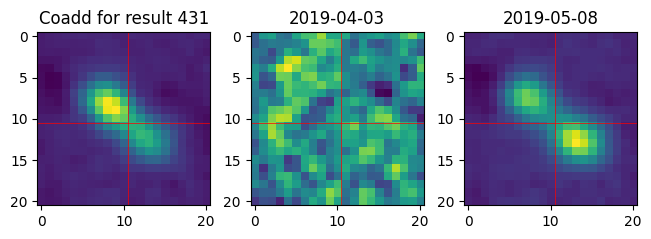

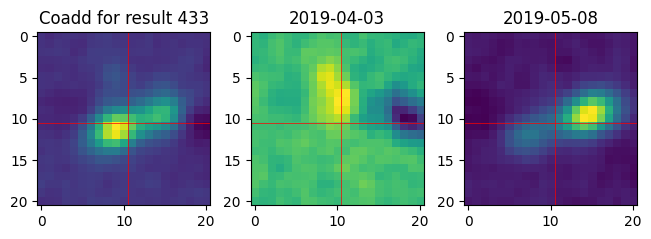

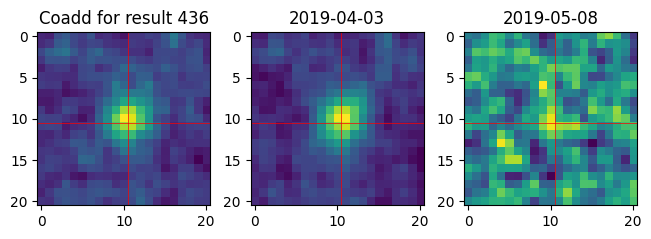

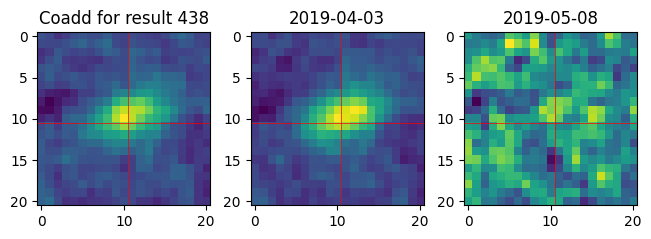

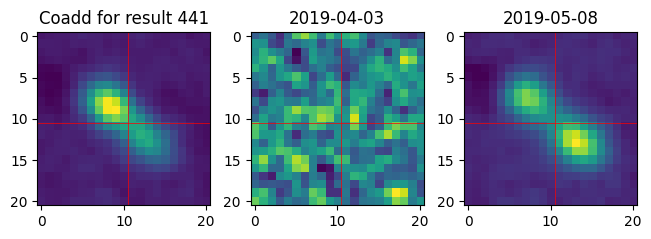

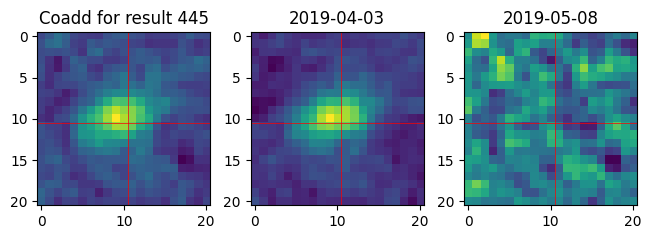

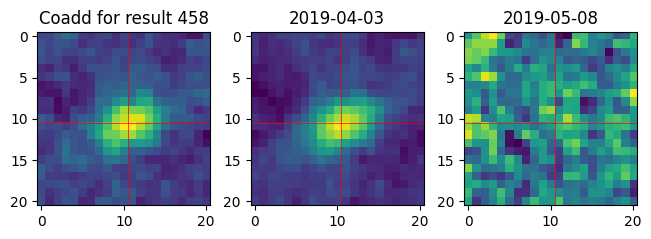

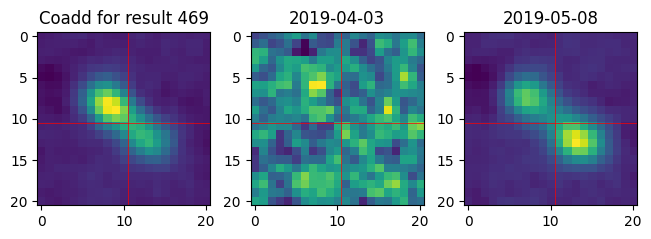

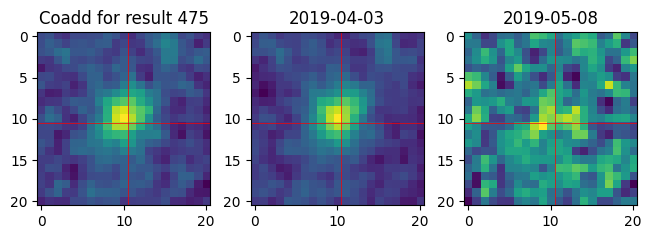

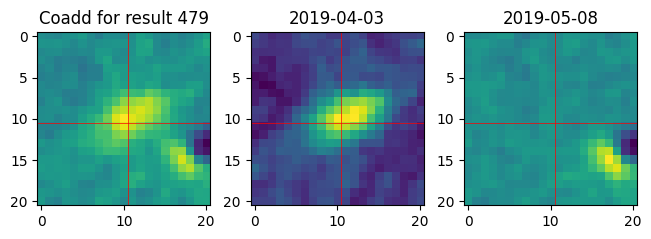

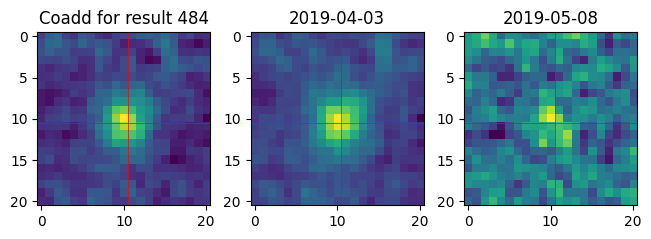

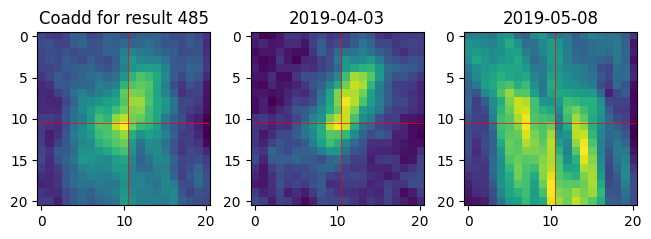

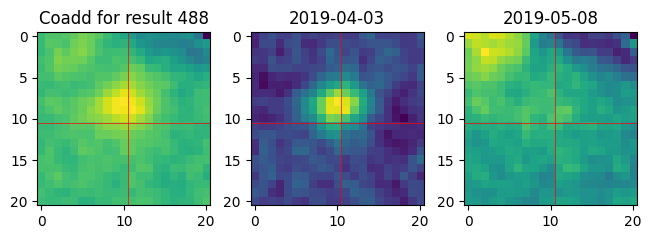

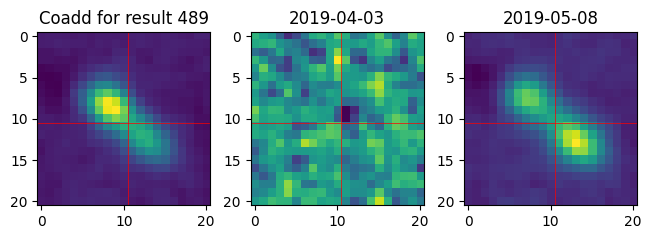

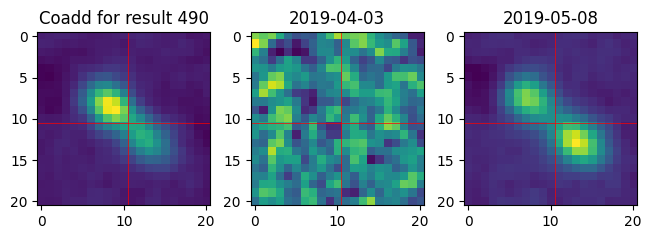

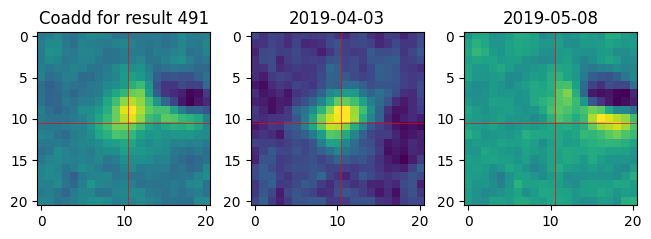

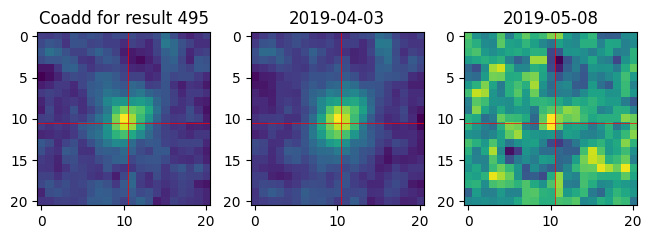

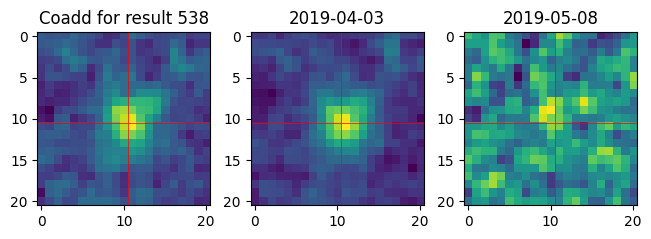

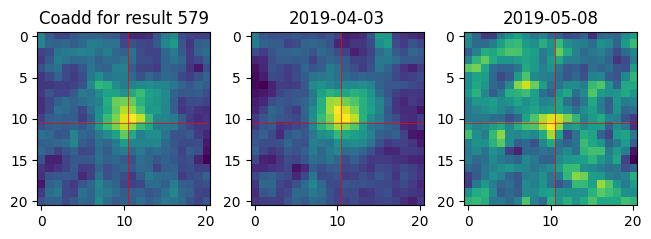

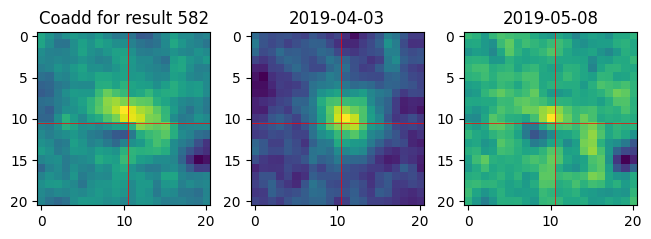

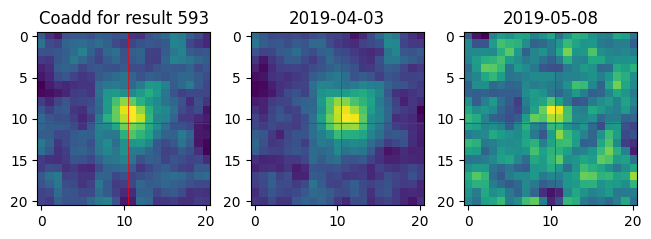

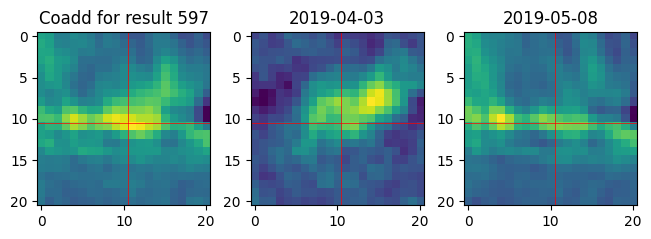

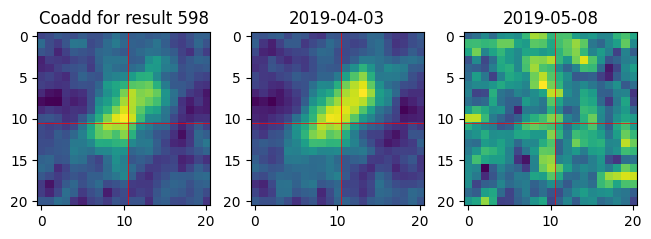

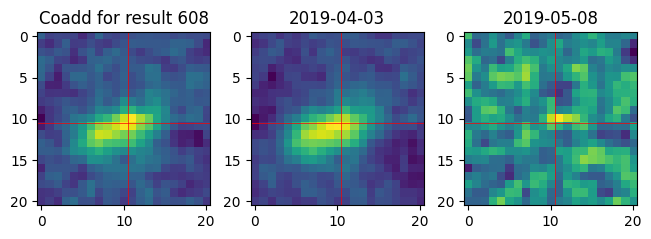

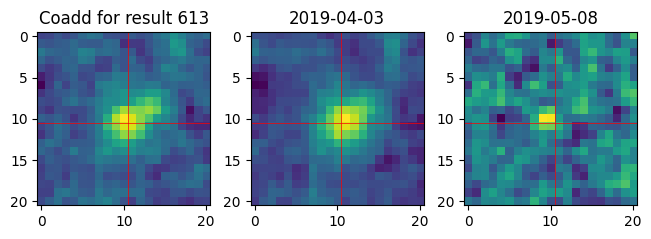

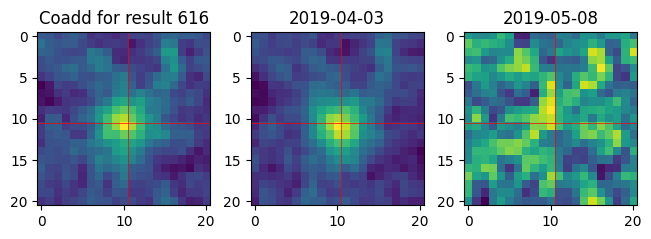

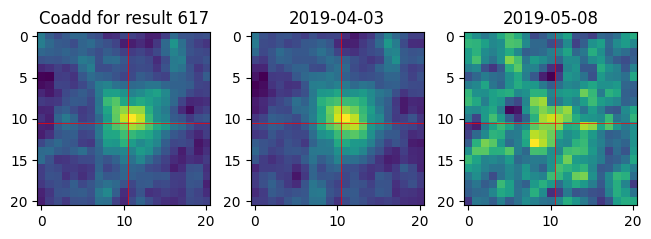

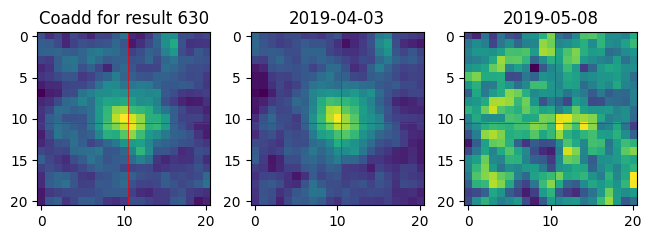

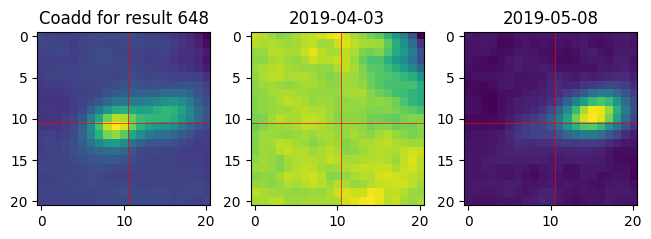

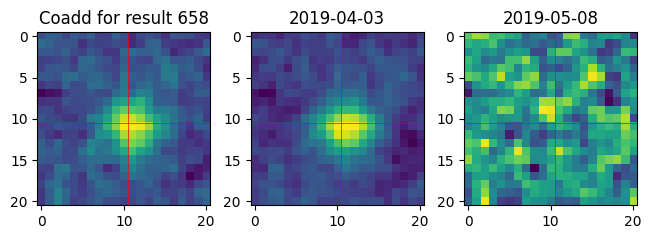

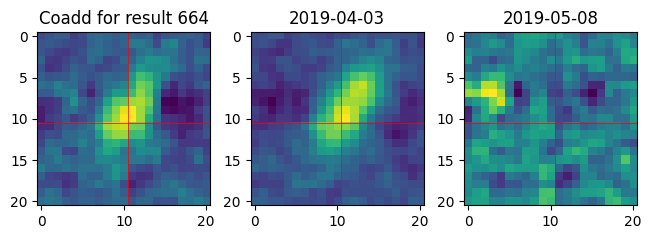

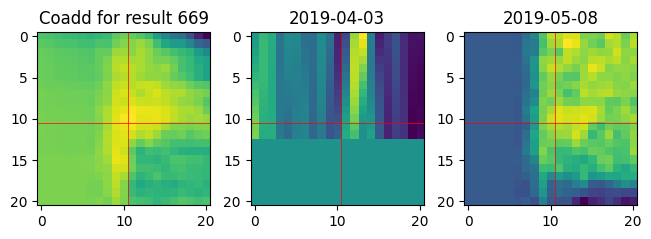

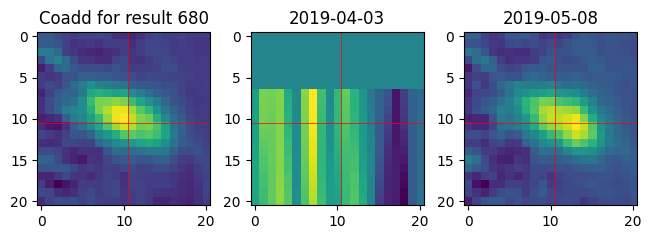

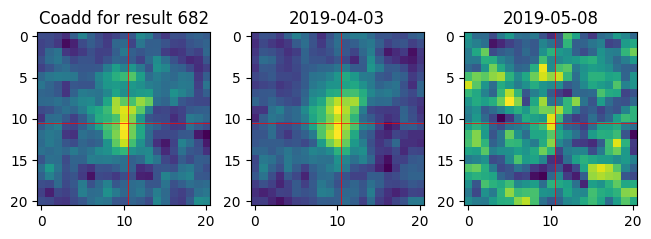

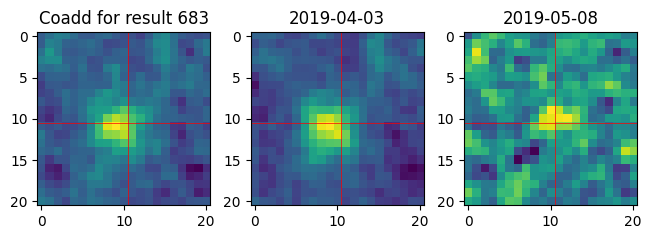

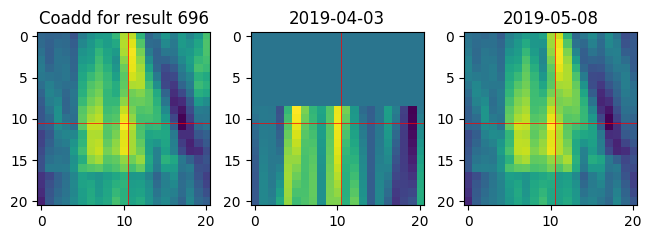

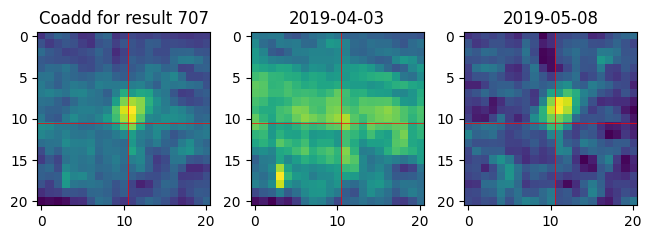

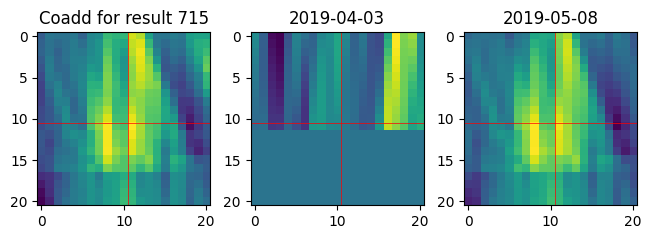

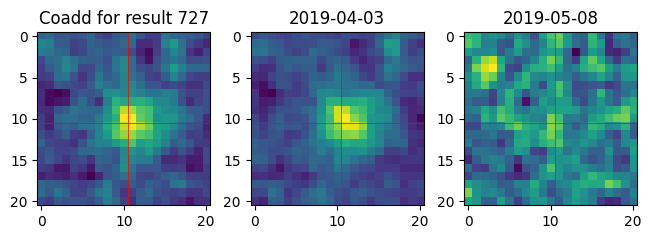

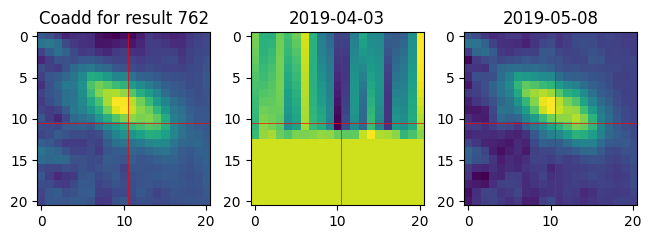

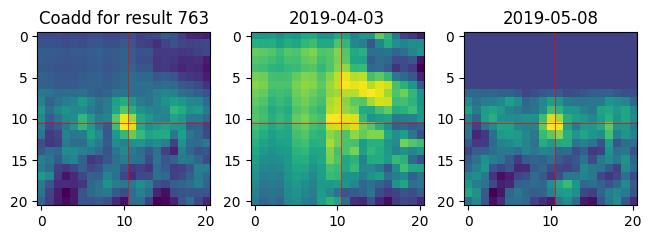

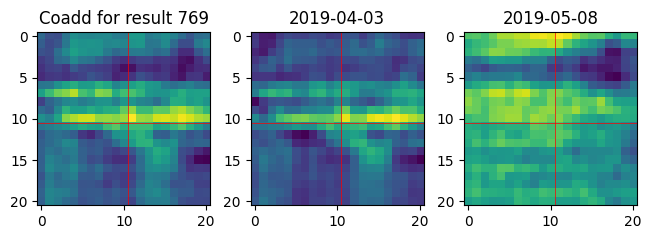

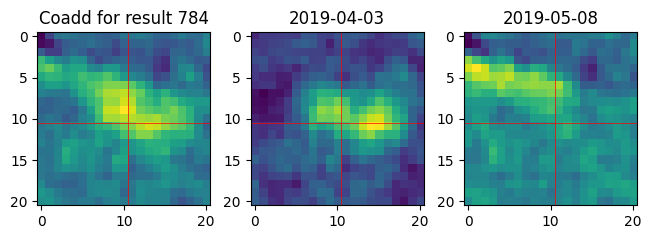

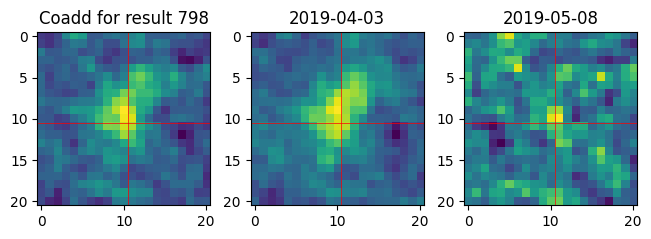

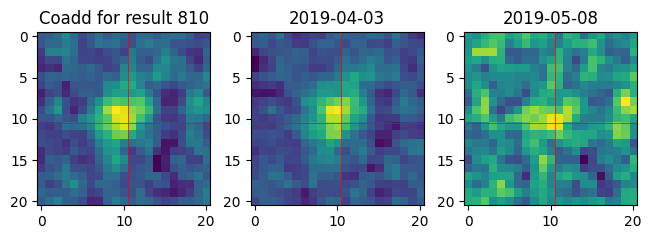

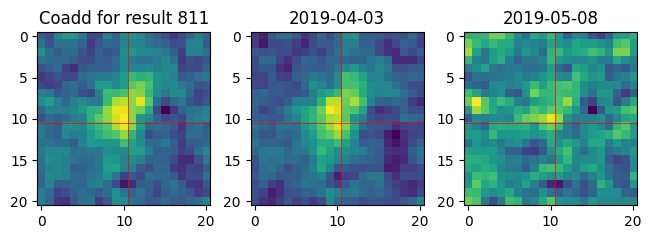

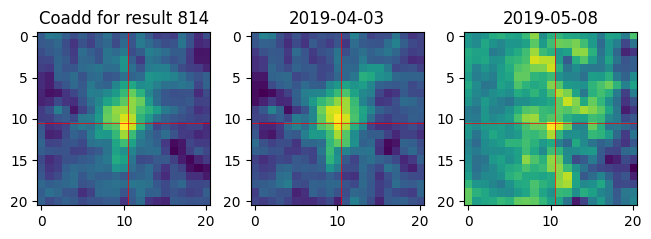

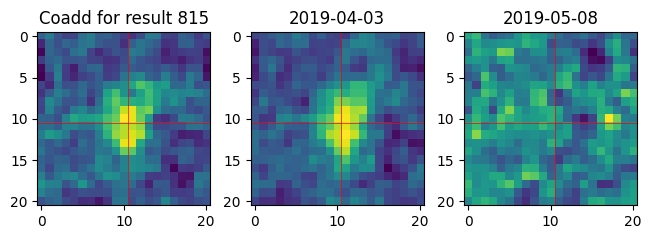

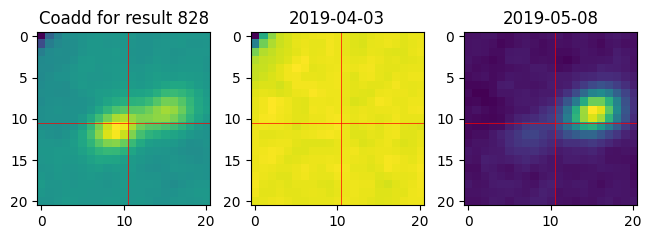

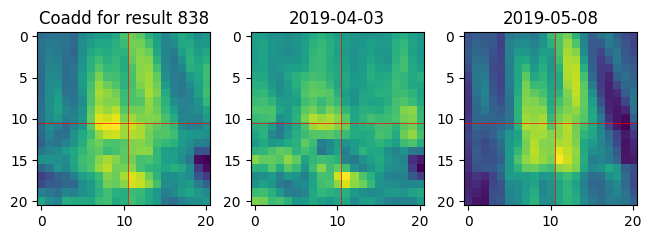

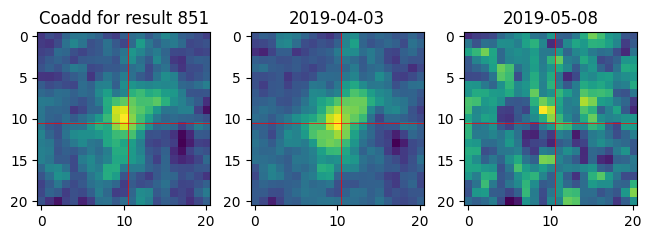

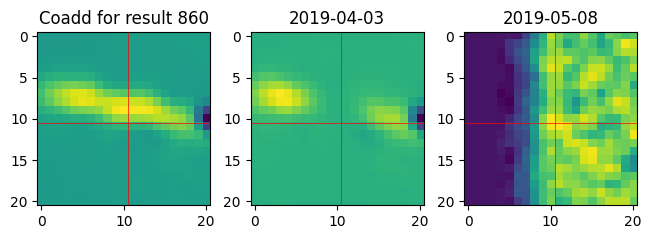

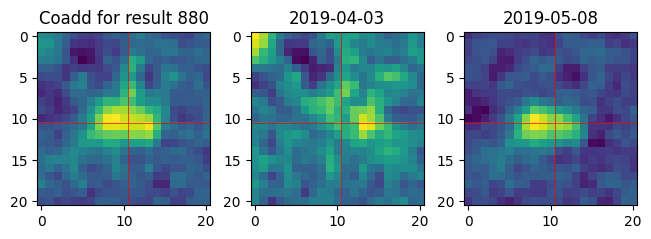

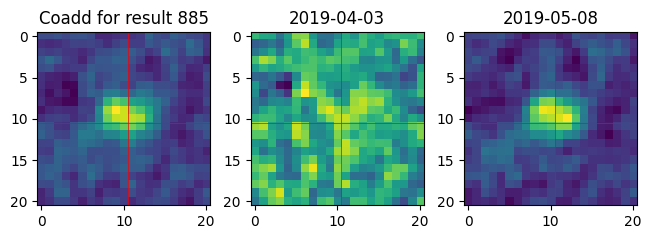

In [9]:
for i in range(len(results)):
    if results[i]["num_days"] >= 2:
        plot_daily_coadds(results, i)

# Search for results that are near known fakes

We have a table of fakes that are present in the data, uniquely identified by the 'ORBITID' column

In [10]:
fakes = Table.read(fakes_path, format="csv")
fakes.sort(["ORBITID", "mjd_mid"]) # Sort by the unique ORBITID for each fake and then observation time
fakes

col0,Unnamed: 0,RA,DEC,EXPNUM,CCDNUM,ORBITID,aei_1,aei_2,aei_3,aei_4,aei_5,aei_6,mjd_mid,TDB,xv_1,xv_2,xv_3,xv_4,xv_5,xv_6,H_VR,AMP,PERIOD,PHASE,d,observatory_1,observatory_2,observatory_3,r,MAG,ut,ut_date,local_obsnight,fit_known_r,fit_5.0,fit_10.0,fit_15.0,fit_20.0,fit_25.0,fit_30.0,fit_31.0,fit_32.0,fit_33.0,fit_34.0,fit_35.0,fit_36.0,fit_37.0,fit_38.0,fit_39.0,fit_40.0,fit_41.0,RA_42.0,Dec_42.0,fit_42.0,fit_43.0,fit_44.0,fit_45.0,fit_46.0,fit_47.0,fit_48.0,fit_49.0,fit_50.0,fit_60.0,fit_70.0,fit_80.0,fit_90.0,fit_100.0,fit_150.0,fit_200.0,DEEP_id,large_pile
int64,int64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str26,str10,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str5
311,311,-143.9249546115954,-11.235192850918104,845577,4,2099,66.83157577666151,0.1402114338833088,38.20716584291712,213.46076958317744,215.2074184912557,-193.84165486729444,58576.20992296842,19.25177473984536,-59.331088814507225,-42.7130830157092,-14.42763881600163,0.2972449394262229,-0.5804487306419694,0.2102534055657792,7.948873683564418,0.0594106968839148,1917.6138972256904,2.2197648966213395,74.51672511877321,-0.9760273212610612,-0.1978288794709856,-0.0858109917681794,73.61078767062216,26.62693480820171,2019-04-03 05:02:17.344471,2019-04-03,2019-04-02,72.7048932422901,4.077237604400063,9.086297315145066,14.089310538076749,19.09081641200746,24.091719765851725,29.09232194583525,30.09241906805309,31.09251011930268,32.092595651586244,33.09267615195109,34.09275205177106,35.09282373448071,36.092891542054986,37.0929557804655,38.093016724297264,39.09307462067269,40.09312969260127,215.49838736068813,-11.108824185423092,41.093182141850654,42.093232151417,43.0932798876584,44.09332550214387,45.093369133260985,46.09341090761845,47.093450941273126,48.09348934080693,49.09352620427443,59.09382725302258,69.09404228501545,79.09420355769159,89.09432899131379,99.0944293378308,149.09473037570362,199.0948808939037,A0c,False
312,312,-143.92497257438345,-11.235184796385138,845578,4,2099,66.83157577666151,0.1402114338833088,38.20716584291712,213.46076958317744,215.2074184912557,-193.84165486729444,58576.2116594204,19.25177949399176,-59.3310874013612,-42.71308577524739,-14.427637816426149,0.2972449663737719,-0.5804487112421407,0.210253412118659,7.948873683564418,0.0594106968839148,1917.6138972256904,2.2197648966213395,74.51672538184681,-0.9760210420431742,-0.1978560980895417,-0.0858226220434362,73.61077494070906,26.627451590672315,2019-04-03 05:04:47.373922,2019-04-03,2019-04-02,72.70486765277599,4.077226894702596,9.086285449442126,14.089298288742503,19.090803971045325,24.09170720995625,29.09230931333178,30.0924064231944,31.09249746286118,32.09258298426411,33.09266347438852,34.09273936455334,35.09281103814437,36.09287883709301,37.092943067331966,38.093004003411295,39.09306189242197,40.09311695734512,215.4984049818199,-11.10882902584724,41.09316939992273,42.09321940312765,43.093267133296834,44.09331274197999,45.0933563675471,46.09339813659077,47.093438165153074,48.09347655980239,49.0935134185808,59.09381442903543,69.09402943367651,79.09419068583912,89.09431610350657,99.09441643725988,149.09471743684196,199.09486793589687,A0c,False
313,313,-143.92499046199325,-11.235176775519522,845579,4,2099,66.83157577666151,0.1402114338833088,38.20716584291712,213.46076958317744,215.2074184912557,-193.84165486729444,58576.21338846388,19.25178422785484,-59.33108599424417,-42.71308852301208,-14.427636821115271,0.2972449932063498,-0.5804486919250795,0.2102534186435809,7.948873683564418,0.0594106968839148,1917.6138972256904,2.2197648966213395,74.51672564379801,-0.9760

astropy allows us to take two catalogus of coordinates (represented by `SkyCoord` objects) and easily search for nearest neighbors between them. 

First, as a simple approximation let's translate the initial (x, y) of each of our results into an (ra, dec). Note that we are using a reflex-corrected WCS from our `WorkUnit` so the (ra, dec) will be in reflex-corrected space.

In [43]:
def get_ra_decs_from_trj(idx, result_table, trajectories):
    # To generate a trajectory object we need times of each valid observation for this result
    is_valid = result_table[idx]["obs_valid"]
    valid_obstimes = []
    for i in range(len(is_valid)):
        if is_valid[i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    # Now we can generate (ra, DEC) coordinates for the trajectory using our work unit's WCS
    return trajectory_predict_skypos(trajectories[idx], wu.wcs, valid_obstimes)

ra_decs = [get_ra_decs_from_trj(i, results, trajectories) for i in range(len(results))]

results.table["ra_dec_start"] = [ra_decs[i][0] for i in range(len(results))]
results.table["ra_dec_end"] = [ra_decs[i][-1] for i in range(len(results))]

In [12]:
fakes_guess_ra = "RA_42.0"
fakes_guess_dec = "Dec_42.0"

Now we can translate our (ra, dec) pairs into single `SkyCoord` objects.

Then we can use astopy's `search_around_sky` to find which KBMOD results are near our known fakes, with a max separation limit of 1 arcsecond

In [44]:
# Get the reflex-corrected (ra, DEC) positions for our fakes  
fake_coords = SkyCoord(ra=fakes[fakes_guess_ra] * u.degree, dec=fakes[fakes_guess_dec] * u.degree)

# Performe the search for if our trajectory start positions were near any fakes
idx1, idx2, sep2dAngle, dist3d = search_around_sky(results["ra_dec_start"], fake_coords, 1 * u.arcsecond)

`idx1` Maps fakes to their nearest neighbors in the results. Each value is an index to a potential finding within our results table.

In [14]:
print(len(idx1))
idx1

3147


array([  6,   6,   6, ..., 878, 878, 878])

In [15]:
idx2

array([96716, 96717, 96718, ..., 46841, 46842, 46843])

In [16]:
potential_fake_starts = np.unique(idx1)
potential_fake_starts

array([  6, 202, 204, 207, 208, 220, 221, 222, 227, 228, 229, 235, 236,
       237, 238, 241, 243, 248, 257, 261, 265, 267, 293, 319, 324, 331,
       332, 339, 351, 356, 364, 366, 377, 386, 388, 389, 395, 401, 406,
       408, 420, 438, 445, 448, 458, 465, 479, 488, 491, 603, 608, 658,
       682, 775, 784, 795, 798, 811, 815, 826, 842, 843, 851, 872, 878])

Let's first examine the first result which we believe might be a fake.

In [17]:
results[potential_fake_starts[0]]

x,y,vx,vy,likelihood,flux,obs_count,psi_curve,phi_curve,obs_valid,stamp,all_stamps,num_days,ra_dec_start,ra_dec_end
,,,,,,,,,,,,,"deg,deg","deg,deg"
int64,int64,float64,float64,float64,float64,int64,float64[189],float64[189],bool[189],"float32[21,21]",object[189],int64,SkyCoord,SkyCoord
3283,2692,-51.415260314941406,-17.59870147705078,409.36207340950784,2025.645503007611,103,0.5943410992622375 .. 0.0,0.00041448348201811314 .. 0.0,True .. False,-190.19298 .. -214.22815,<kbmod.search.RawImage object at 0x7fd743d2e3b0> .. <kbmod.search.RawImage object at 0x7fd743d40ff0>,1,"215.42458389051228,-13.80325947494971","215.42459050497553,-13.803261675856994"


/astro/users/wbeebe/.conda/envs/kbmod_new_wu/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/astro/users/wbeebe/.conda/envs/kbmod_new_wu/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


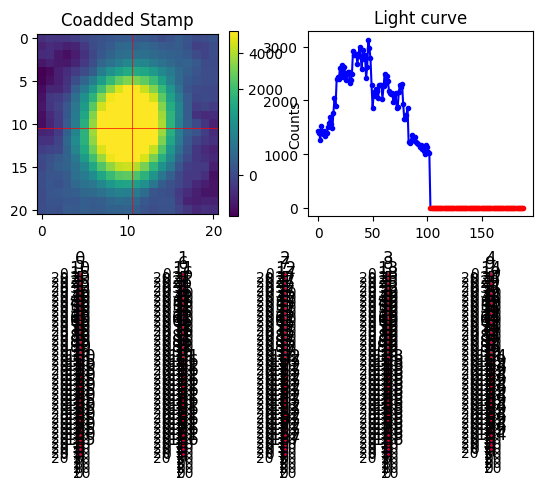

In [18]:
# helper function to plot a row of the results table
plot_result_row(results[potential_fake_starts[0]])

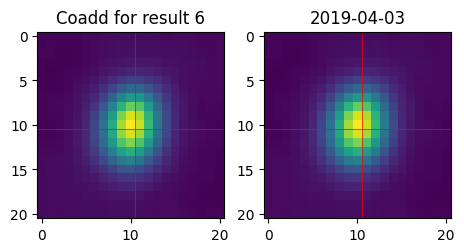

In [19]:
plot_daily_coadds(results, potential_fake_starts[0])

`idx2` shows the inverse mapping of which fakes might be potential results. Here its values are indices within our fakes table.

So taking the first potential match we examined above, we can use the corresponding index (in this case 0) to inspect within our fakes table.


In [20]:
fakes[idx2[0]]["ORBITID"]

3466970

In [21]:
def find_fakes_matches(fakes_table, idx1, idx2):
    # Matches a result's index index in the results table to its corresponding fake orbit ID
    matches = {}
    for i in range(len(idx1)):
        if idx1[i] not in matches:
            matches[idx1[i]] = set()
        matches[idx1[i]].add(fakes[idx2[i]]["ORBITID"])
        
    return matches
    
result_start_to_fakes = find_fakes_matches(fakes, idx1, idx2)
result_start_to_fakes
    

{6: {3466970},
 202: {3670663},
 204: {3670663},
 207: {3670663},
 208: {3670663},
 220: {3670663},
 221: {3670663},
 222: {3670663},
 227: {3670663},
 228: {3670663},
 229: {3670663},
 235: {3670663},
 236: {3670663},
 237: {4661373},
 238: {3670663},
 241: {4661373},
 243: {4661373},
 248: {3670663},
 257: {4661373},
 261: {4661373},
 265: {3670663},
 267: {3670663},
 293: {4661373},
 319: {3671282},
 324: {153366},
 331: {153366},
 332: {3671282},
 339: {3671282},
 351: {153366},
 356: {4661373},
 364: {4661373},
 366: {3671282},
 377: {4661373},
 386: {4661373},
 388: {4661373},
 389: {4661373},
 395: {3671282},
 401: {4661373},
 406: {3671282},
 408: {4661373},
 420: {1735513},
 438: {1735513},
 445: {1735513},
 448: {1735513},
 458: {153366},
 465: {1735513},
 479: {153366},
 488: {3671282},
 491: {3671282},
 603: {3671282},
 608: {1735513},
 658: {3671282},
 682: {1653264},
 775: {140561},
 784: {4661373},
 795: {1653264},
 798: {1653264},
 811: {1653264},
 815: {1653264},
 826:

In [22]:
fakes[fakes["ORBITID"] == 4661373]

col0,Unnamed: 0,RA,DEC,EXPNUM,CCDNUM,ORBITID,aei_1,aei_2,aei_3,aei_4,aei_5,aei_6,mjd_mid,TDB,xv_1,xv_2,xv_3,xv_4,xv_5,xv_6,H_VR,AMP,PERIOD,PHASE,d,observatory_1,observatory_2,observatory_3,r,MAG,ut,ut_date,local_obsnight,fit_known_r,fit_5.0,fit_10.0,fit_15.0,fit_20.0,fit_25.0,fit_30.0,fit_31.0,fit_32.0,fit_33.0,fit_34.0,fit_35.0,fit_36.0,fit_37.0,fit_38.0,fit_39.0,fit_40.0,fit_41.0,RA_42.0,Dec_42.0,fit_42.0,fit_43.0,fit_44.0,fit_45.0,fit_46.0,fit_47.0,fit_48.0,fit_49.0,fit_50.0,fit_60.0,fit_70.0,fit_80.0,fit_90.0,fit_100.0,fit_150.0,fit_200.0,DEEP_id,large_pile
int64,int64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str26,str10,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str5
3544146,3544146,-143.97072557018188,-13.856241736094567,845580,42,4661373,62.69341850618922,0.3945734107210352,26.55340390474812,38.69433107570047,289.3717457915171,107.8209856845104,58576.21534627589,19.251789588052137,-48.42531434626397,-34.70953056078255,-14.558846443945807,0.6599658956812358,-0.1711071010851299,-0.44007745107724,6.364200596818325,0.0,0.0,0.0,61.33288343998488,-0.976007692999132,-0.1979138841937261,-0.0858473153491347,60.43141642625736,24.20898137804321,2019-04-03 05:10:05.918237,2019-04-03,2019-04-02,59.52998479407756,4.081169731787565,9.090665630950904,14.093823591624917,19.09540176188052,24.0963484767548,29.09697955859532,30.097081342050515,31.097176763128573,32.09726640033289,33.09735076409281,34.09743030649091,35.09750542936866,36.09757649111724,37.09764381239591,38.09770768097041,39.097768355825416,40.09782607067505,215.44804322729925,-13.67336297019583,41.09788103697181,42.09793344649557,43.09798347358942,44.09803127709739,45.098077002049365,46.09812078113089,47.098162735969176,48.09820297826168,49.09824161076919,59.09855710639206,69.0987824573033,79.09895146903862,89.09908292186212,99.09918808370276,149.09950356738148,199.09966130841207,A0b,True
3544147,3544147,-143.97074789276712,-13.856235990358073,845581,42,4661373,62.69341850618922,0.3945734107210352,26.55340390474812,38.69433107570047,289.3717457915171,107.8209856845104,58576.21705656728,19.25179427057469,-48.42531125595869,-34.70953136199534,-14.55884850461837,0.6599659345318485,-0.1711070732384013,-0.4400774393969821,6.364200596818325,0.0,0.0,0.0,61.332881942610896,-0.9760014927379458,-0.1979406882175148,-0.085858770191839,60.43140176839587,24.20898079833048,2019-04-03 05:12:33.687413,2019-04-03,2019-04-02,59.52995709353816,4.081158831179751,9.090653559978175,14.093811132338484,19.09538910863641,24.09633570718213,29.09696671148536,30.097068482435507,31.097163891790306,32.09725351798206,33.09733787137737,34.097417404003274,35.097492517651844,36.09756357067023,37.097630883678285,38.09769474440638,39.09775541180737,40.09781311956666,215.44805640987144,-13.673369077981384,41.09786807911078,42.09792048219602,43.097970503144055,44.09801830077939,45.0980640201141,46.09810779381742,47.09814974350163,48.098189980850464,49.09822860861205,59.0985440654774,69.09876938870546,79.09893837967874,89.09906981635419,99.0991749652765,149.09949041020064,199.09964813185425,A0b,True
3544148,3544148,-143.97077023693987,-13.85623023843535,845582,42,4661373,62.69341850618922,0.3945734107210352,26.55340390474812,38.69433107570047,289.3717457915171,107.8209856845104,58576.21876838882,19.25179895728661,-48.4253081628884,-34.70953216392483,-14.558850567134511,0.6599659734172202,-0.1711070453667561,-0.4400774277062715,6.364200596818325,0.0,0.0,0.0,61.33288044389722,-0.9759952820070824,-0.1979675146950212,-0.0858702352140177,60.431387102183045,24.208980218270096,2019-04-03 

# Now see if the end points of any of the trajectories are also near the endpoints of our fakes

In [45]:
idx1_end, idx2_end, sep2dAngle_end, dist3d_end = search_around_sky(results["ra_dec_end"], fake_coords, 1 * u.arcsecond)

In [46]:
idx1_end

array([  6,   6,   6, ..., 878, 878, 878])

In [47]:
idx2_end

array([96786, 96787, 96788, ..., 46847, 46848, 46849])

In [48]:
potential_fake_ends = np.unique(idx1_end)
potential_fake_ends

array([  6,  44,  48,  55,  92, 110, 112, 121, 142, 155, 158, 161, 163,
       165, 172, 188, 190, 192, 202, 204, 207, 208, 213, 220, 221, 222,
       227, 228, 229, 232, 235, 236, 238, 241, 243, 249, 253, 254, 255,
       261, 265, 267, 271, 293, 311, 314, 315, 322, 325, 330, 332, 340,
       346, 361, 362, 363, 364, 366, 375, 383, 391, 398, 400, 401, 403,
       404, 423, 425, 426, 427, 428, 431, 433, 441, 469, 489, 490, 521,
       603, 609, 644, 648, 729, 757, 775, 795, 828, 842, 843, 872, 878])

In [49]:
result_end_to_fakes = find_fakes_matches(fakes, idx1_end, idx2_end)
result_end_to_fakes

{6: {3466970},
 44: {315826},
 48: {315826},
 55: {315826},
 92: {315826},
 110: {315826},
 112: {315826},
 121: {315826},
 142: {315826},
 155: {315826},
 158: {2424601},
 161: {315826},
 163: {315826},
 165: {315826},
 172: {315826},
 188: {315826},
 190: {315826},
 192: {315826},
 202: {3670663},
 204: {3670663},
 207: {3670663},
 208: {3670663},
 213: {315826},
 220: {3670663},
 221: {3670663},
 222: {3670663},
 227: {3670663},
 228: {3670663},
 229: {3670663},
 232: {315826},
 235: {3670663},
 236: {3670663},
 238: {3670663},
 241: {4661373},
 243: {4661373},
 249: {3670663},
 253: {315826},
 254: {315826},
 255: {315826},
 261: {4661373},
 265: {3670663},
 267: {3670663},
 271: {315826},
 293: {4661373},
 311: {315826},
 314: {315826},
 315: {2424601},
 322: {2424601},
 325: {2424601},
 330: {4661373},
 332: {3671282},
 340: {315826},
 346: {2424601},
 361: {2424601},
 362: {2424601},
 363: {2424601},
 364: {4661373},
 366: {3671282},
 375: {2424601},
 383: {2424601},
 391: {2424

# Look for Fakes Matching Both the Start and Endpoint

In [50]:
# Maps of result indices that could be matched to a fake for both their start and end coordinate
result_full_fake_match = {}
for r in result_start_to_fakes:
    # Check for results that also were matched to a fake for their end coordinate
    if r in result_end_to_fakes:
        shared_fakes = result_start_to_fakes[r].intersection(result_end_to_fakes[r])
        if len(shared_fakes) > 0:
            result_full_fake_match[r] = shared_fakes
result_full_fake_match

{6: {3466970},
 202: {3670663},
 204: {3670663},
 207: {3670663},
 208: {3670663},
 220: {3670663},
 221: {3670663},
 222: {3670663},
 227: {3670663},
 228: {3670663},
 229: {3670663},
 235: {3670663},
 236: {3670663},
 238: {3670663},
 241: {4661373},
 243: {4661373},
 261: {4661373},
 265: {3670663},
 267: {3670663},
 293: {4661373},
 332: {3671282},
 364: {4661373},
 366: {3671282},
 401: {4661373},
 603: {3671282},
 775: {140561},
 795: {1653264},
 842: {140561},
 843: {4964962},
 872: {140561},
 878: {1653264}}

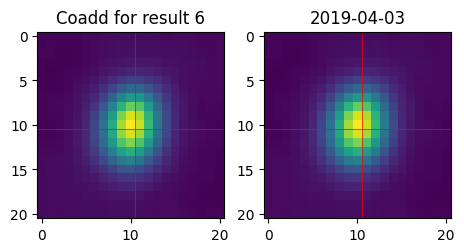

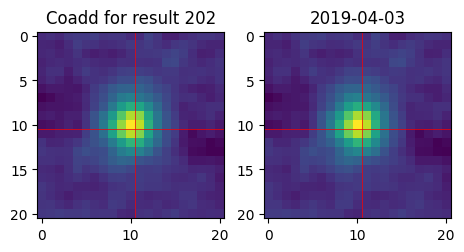

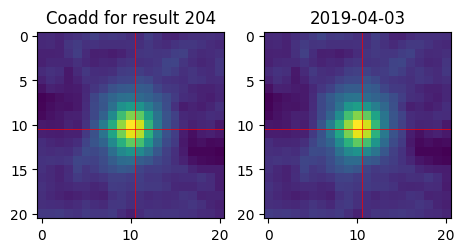

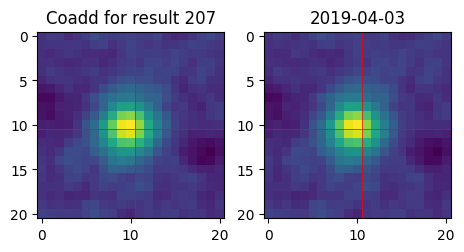

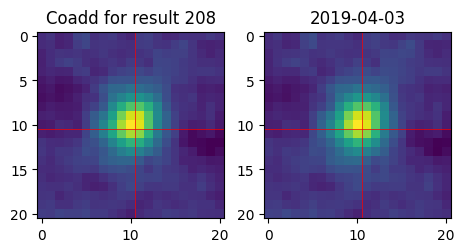

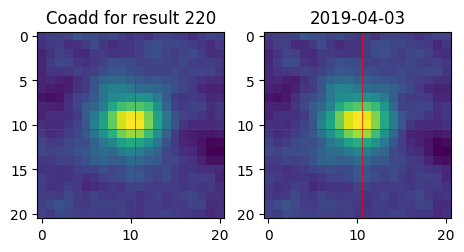

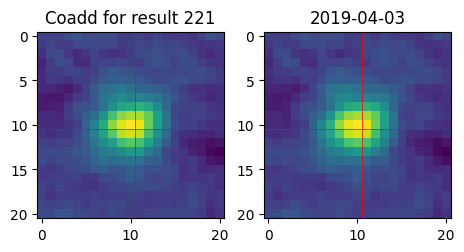

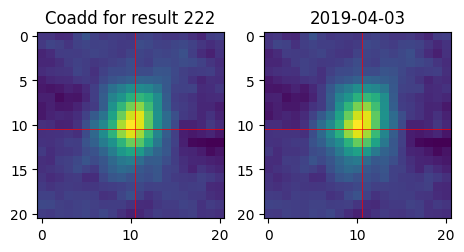

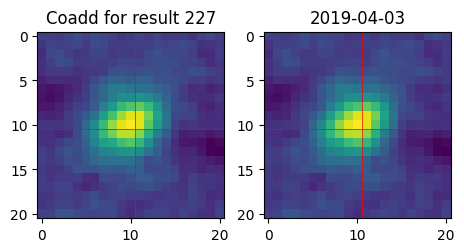

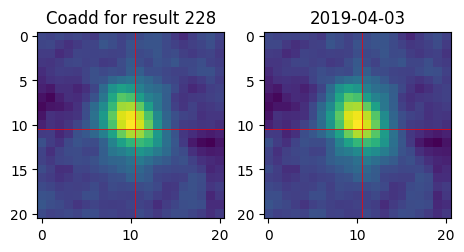

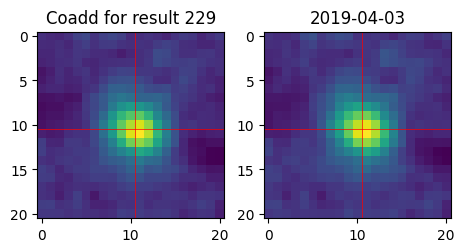

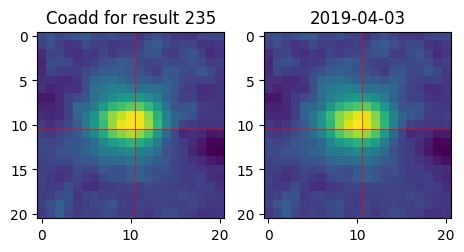

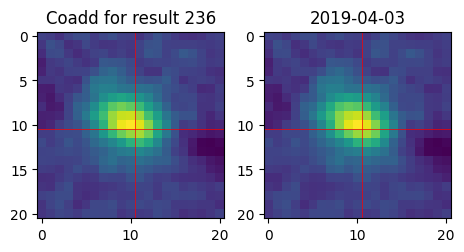

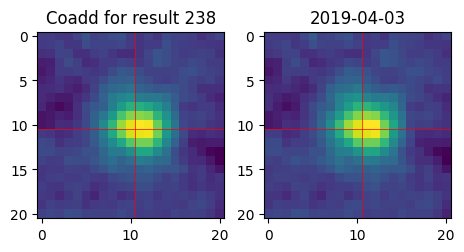

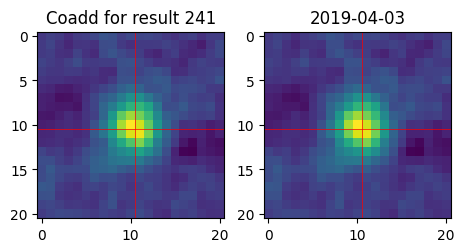

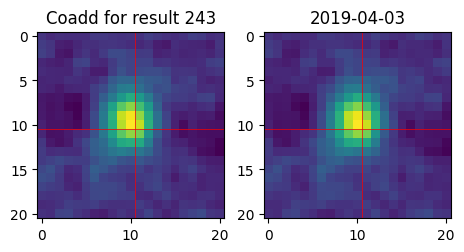

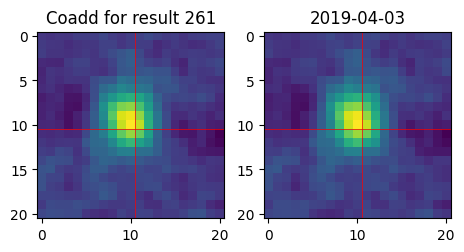

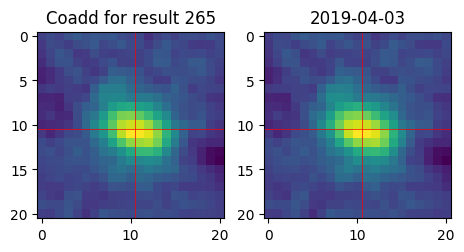

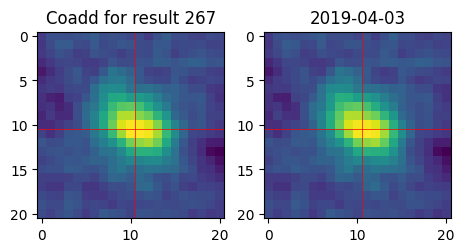

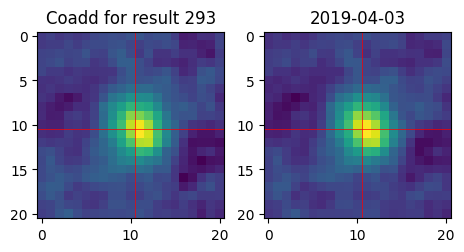

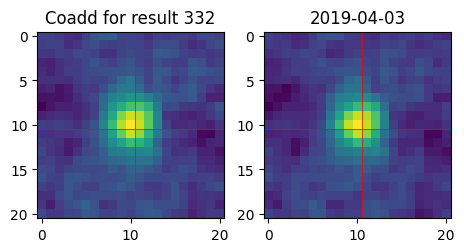

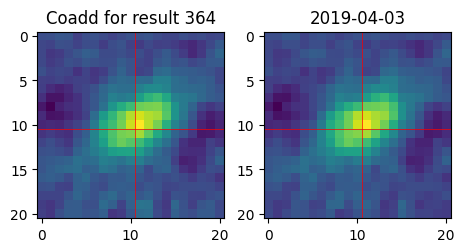

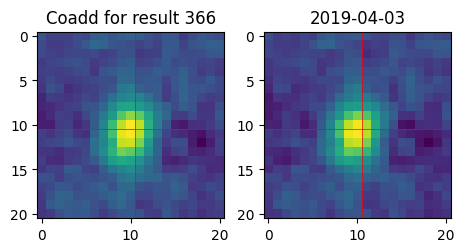

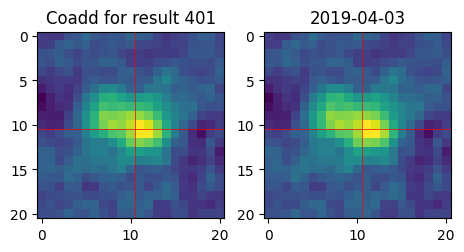

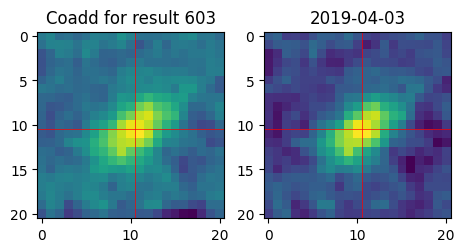

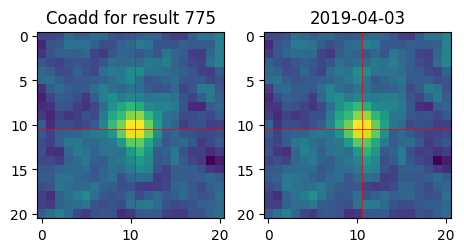

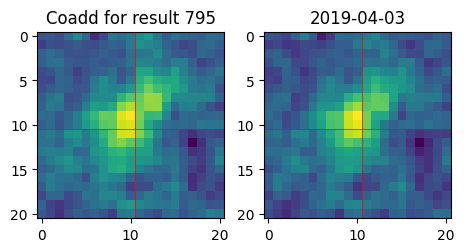

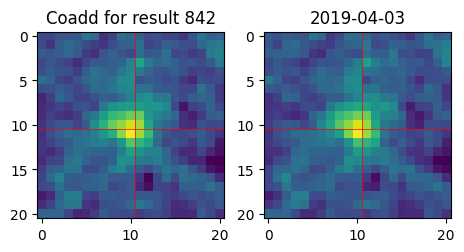

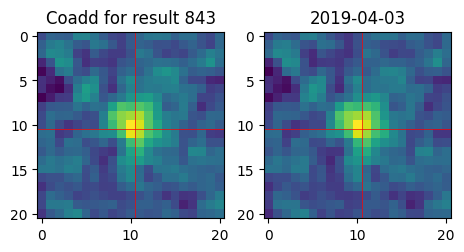

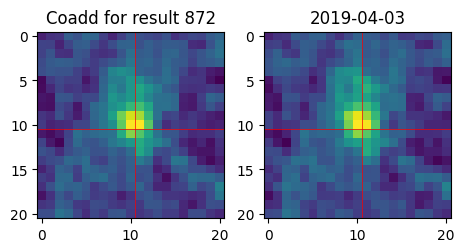

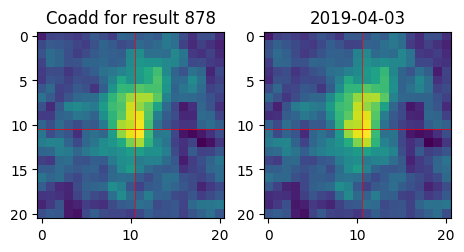

In [52]:
for idx in result_full_fake_match:
    plot_daily_coadds(results, idx)

Result 6 is interesting, so let's examine its matching fake(s)

In [54]:
result_full_fake_match[6]

{3466970}

# Examine a given Fake

Let's evaluate the linearity and velocities of our fake

In [55]:
CURR_ORBIT_ID = 3466970

In [56]:
def evaluate_fake(fake_table, fake_orbit_id, verbose=True):
    our_fake = fake_table[fake_table["ORBITID"] == fake_orbit_id]

    our_fake.sort("mjd_mid")
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))

    A = np.vstack([fake_x, np.ones(len(fake_x))]).T
    m, c = np.linalg.lstsq(A, fake_y, rcond=None)[0]

    # Make predictions
    y_pred = m * fake_x + c

    # Compute R-squared
    ss_res = np.sum((fake_y - y_pred) ** 2)
    ss_tot = np.sum((fake_y - np.mean(fake_y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    elapsed_time = our_fake["mjd_mid"][-1] - our_fake["mjd_mid"][0]
    fake_vx = float(fake_x[-1] - fake_x[0]) / elapsed_time
    fake_vy = float(fake_y[-1] - fake_y[0]) / elapsed_time
    fake_v = math.sqrt(fake_vx*fake_vx + fake_vy*fake_vy)

    print(f'For fake ORBITID={fake_orbit_id}, R^2={r_squared} and its pixel/day velocities are vx={fake_vx} vy={fake_vy}, v={fake_v}')
    return r_squared, fake_vx, fake_vy, fake_v
    

evaluate_fake(fakes, CURR_ORBIT_ID)

For fake ORBITID=3466970, R^2=0.999999043622657 and its pixel/day velocities are vx=-63.0329965962609 vy=14.220777059604767, v=64.61725125756449


(0.999999043622657, -63.0329965962609, 14.220777059604767, 64.61725125756449)

# Plot Fake by Day
Here we align 

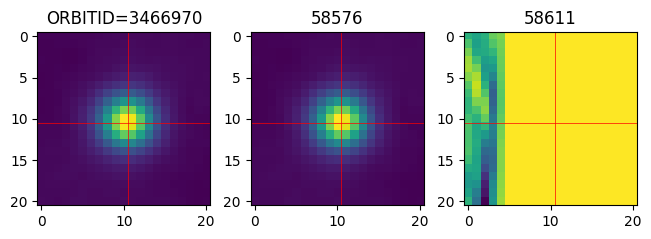

In [57]:
def manual_coadd(stamps, stamp_indices, plot_me=False):
    # Manually coadds stamps at a given set of indices in the image stack
    result_stamp = stamps[stamp_indices[0]].image.copy()
    for i in stamp_indices[1:]:
        result_stamp += stamps[i].image
    if plot_me:
        plt.imshow(result_stamp, cmap='grey')
    return result_stamp

def plot_daily_fake_stamps(stack, fakes_table, fake_orbit_id):
    # Pull the sorted fakes table
    our_fake = fakes_table[fakes_table["ORBITID"] == fake_orbit_id]
    our_fake.sort("mjd_mid")
    
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))
    
    imgs = stack.get_images()
    
    stack_obstimes = [imgs[i].get_obstime() for i in range(len(imgs))]
    fake_times = our_fake["mjd_mid"]

    # Match to the closest times
    # 
    epsilon = 0.01
    closest_times = [-1 for i in fake_times] # List indices in the image stack with the closest obstime to our fake time
    for i in range(len(fake_times)):
        curr_fake_time = fake_times[i]
        for j in range(len(stack_obstimes)):
            old_closest_time = stack_obstimes[closest_times[i]]
            curr_time = stack_obstimes[j]
            curr_diff = abs(curr_time - curr_fake_time)
            if curr_diff <= epsilon:
                if closest_times[i] == -1 or curr_diff < abs(old_closest_time - curr_fake_time):
                    closest_times[i] = j
    
    # Generate fake_stamps
    fake_stamps = []
    for i in range(len(closest_times)):
        if closest_times[i] != -1:
            curr_img = imgs[closest_times[i]].get_science()
            fake_stamps.append(curr_img.create_stamp(fake_x[i], fake_y[i], 10, False))
    
    # Plot the coadds for the whole and all days
    img_to_plot = [manual_coadd(fake_stamps, range(len(fake_stamps)), plot_me=False)]
    labels = [f'ORBITID={fake_orbit_id}']
    for day in set([int(x) for x in fake_times]):
        current_idx = []
        for i in range(len(closest_times)):
            if int(imgs[closest_times[i]].get_obstime()) == day: #fake_times[i] == day:
                current_idx.append(i)
        img_to_plot.append(manual_coadd(fake_stamps, current_idx, plot_me=False))
        labels.append(str(day))
    plot_multiple_images(img_to_plot, labels=labels) 

plot_daily_fake_stamps(stack, fakes, CURR_ORBIT_ID)

# Plot a Given KBMOD Result Trajectory Alongside a Given Fake

In the next cell we provide a variety of helper functions for evaluating a KBMOD trajectory alongside a given fake

In [78]:
def get_x_y_from_trj(idx, result_table, trajectories, times):
    dt = np.array(times)
    dt -= dt[0]

    trj = trajectories[idx]
    # Predict locations in pixel space.
    x_vals = trj.x + trj.vx * dt
    y_vals = trj.y + trj.vy * dt

    return x_vals, y_vals

def plot_res_traj(result_table, res_idx, trajectories):
    valid_obstimes = []
    for i in range(len(result_table[res_idx]["obs_valid"])):
        if result_table[res_idx]["obs_valid"][i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    res_x, res_y = get_x_y_from_trj(res_idx, result_table, trajectories, valid_obstimes)
    
    min_date = min(valid_obstimes)
    max_date = max(valid_obstimes)
    day_sep = int(max_date) - int(min_date)

    kbmod_plt = plt.scatter(res_x, res_y, color='blue', label="KBMOD trajectory", marker='.')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title(f'KBMOD Result Trajectory {res_idx} ({day_sep} day separation)')
    plt.show()

def plot_fake(fake_table, orbit_id):
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))
    
    min_date = min(our_fake["mjd_mid"])
    max_date = max(our_fake["mjd_mid"])
    day_sep = int(max_date) - int(min_date)

    fake_plt = plt.scatter(fake_x, fake_y, color='red', label="fakes", marker='.')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title(f'Fake ORBIT_ID={orbit_id} ({day_sep} day separation)')
    plt.show()
    
def plot_fake_ra_dec(fake_table, orbit_id):
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    #fake_x, fake_y = SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree)
    
    min_date = min(our_fake["mjd_mid"])
    max_date = max(our_fake["mjd_mid"])
    day_sep = int(max_date) - int(min_date)

    fake_plt = plt.scatter(our_fake[fakes_guess_ra], our_fake[fakes_guess_dec], color='red', label="fakes", marker='.')
    plt.xlabel('ra (degrees)')
    plt.ylabel('dec (degrees)')
    plt.title(f'Fake ORBIT_ID={orbit_id} ({day_sep} day separation)')
    plt.show()
    
def plot_fake_ra_dec_single_night(fake_table, orbit_id, night):
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    our_fake =  our_fake[our_fake["local_obsnight"] == night]
    #fake_x, fake_y = SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree)
    
    min_date = min(our_fake["mjd_mid"])
    max_date = max(our_fake["mjd_mid"])
    day_sep = int(max_date) - int(min_date)

    fake_plt = plt.scatter(our_fake[fakes_guess_ra], our_fake[fakes_guess_dec], color='red', label="fakes", marker='.')
    plt.xlabel('ra (degrees)')
    plt.ylabel('dec (degrees)')
    plt.title(f'Fake ORBIT_ID={orbit_id} ({night})')
    plt.show()
    
def plot_fake_x_y_single_night(fake_table, orbit_id, night):
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    our_fake =  our_fake[our_fake["local_obsnight"] == night]
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))
    
    min_date = min(our_fake["mjd_mid"])
    max_date = max(our_fake["mjd_mid"])
    day_sep = int(max_date) - int(min_date)

    fake_plt = plt.scatter(fake_x, fake_y, color='red', label="fakes", marker='.')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title(f'Fake ORBIT_ID={orbit_id} ({night})')
    plt.show()
    
    
def plot_res_traj_and_fake(result_table, res_idx, trajectories, fake_table, orbit_id):
    valid_obstimes = []
    for i in range(len(result_table[res_idx]["obs_valid"])):
        if result_table[res_idx]["obs_valid"][i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    res_x, res_y = get_x_y_from_trj(res_idx, result_table, trajectories, valid_obstimes)
    
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))
    
    min_date = min(min(valid_obstimes), min(our_fake["mjd_mid"]))
    max_date = max(max(valid_obstimes), max(our_fake["mjd_mid"]))
    day_sep = int(max_date) - int(min_date)

    kbmod_plt = plt.scatter(res_x, res_y, color='blue', label="KBMOD trajectory", marker='|',  alpha=0.5)
    fake_plt = plt.scatter(fake_x, fake_y, color='red', label="fakes", marker='_',  alpha=0.5)
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title(f'KBMOD Result Trajectory {res_idx} vs Fake ORBIT_ID={orbit_id} ({day_sep} day separation)')
    plt.legend((kbmod_plt, fake_plt), ("KBMOD trajectory", "fake"))
    plt.show()
    

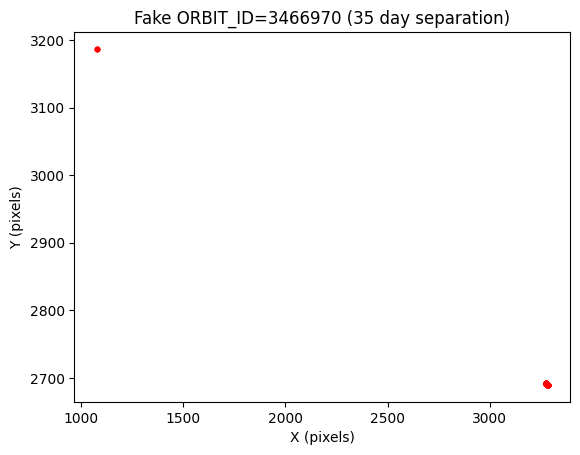

In [59]:
plot_fake(fakes, CURR_ORBIT_ID)

## Plot the result and fake trajectories

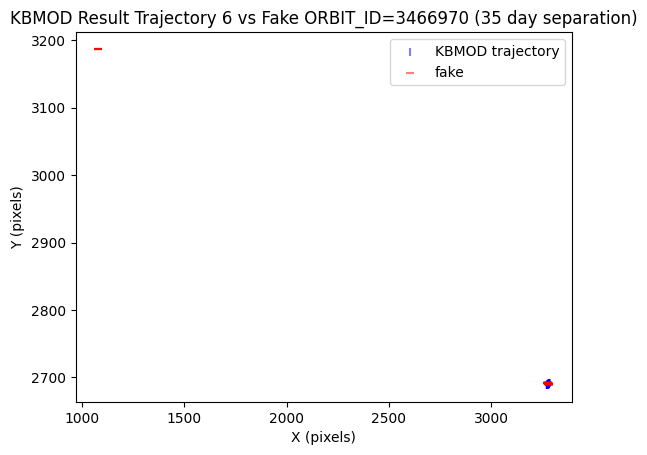

In [80]:
plot_res_traj_and_fake(results, 6, trajectories, fakes, CURR_ORBIT_ID)

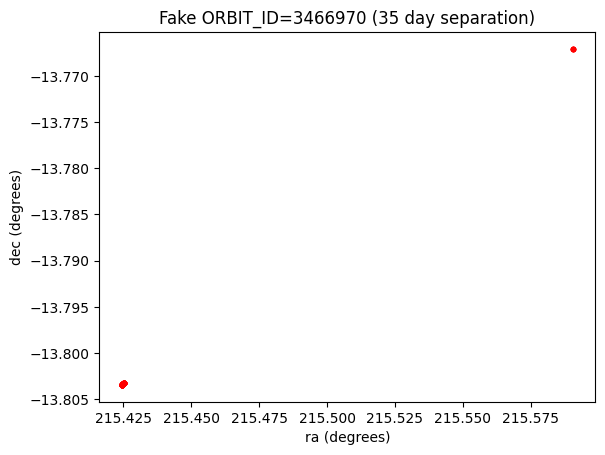

In [77]:
plot_fake_ra_dec(fakes, CURR_ORBIT_ID)

We can get the nights are fake appeared on and plot each one

In [72]:
nights = set(fakes[fakes["ORBITID"] == CURR_ORBIT_ID]["local_obsnight"])
nights


{'2019-04-02', '2019-05-07'}

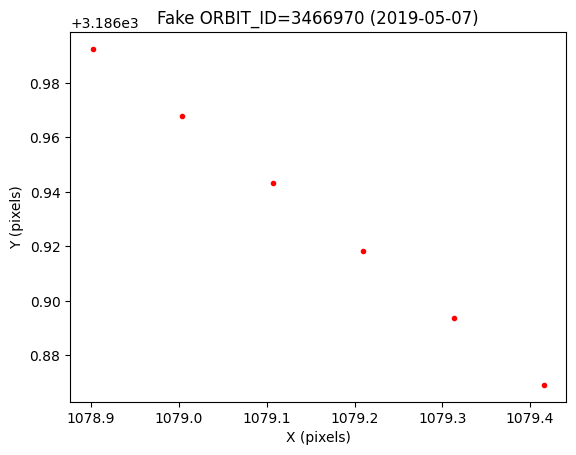

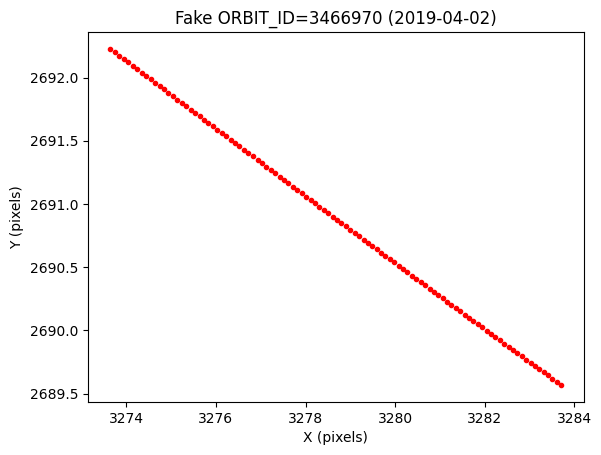

In [81]:
for night in nights:
    plot_fake_x_y_single_night(fakes, CURR_ORBIT_ID, night)

We can see that this fake was hard to find since on the second night

In [70]:
single_night = fakes[fakes["ORBITID"] == CURR_ORBIT_ID]
single_night[single_night["local_obsnight"] == "2019-05-07"]

col0,Unnamed: 0,RA,DEC,EXPNUM,CCDNUM,ORBITID,aei_1,aei_2,aei_3,aei_4,aei_5,aei_6,mjd_mid,TDB,xv_1,xv_2,xv_3,xv_4,xv_5,xv_6,H_VR,AMP,PERIOD,PHASE,d,observatory_1,observatory_2,observatory_3,r,MAG,ut,ut_date,local_obsnight,fit_known_r,fit_5.0,fit_10.0,fit_15.0,fit_20.0,fit_25.0,fit_30.0,fit_31.0,fit_32.0,fit_33.0,fit_34.0,fit_35.0,fit_36.0,fit_37.0,fit_38.0,fit_39.0,fit_40.0,fit_41.0,RA_42.0,Dec_42.0,fit_42.0,fit_43.0,fit_44.0,fit_45.0,fit_46.0,fit_47.0,fit_48.0,fit_49.0,fit_50.0,fit_60.0,fit_70.0,fit_80.0,fit_90.0,fit_100.0,fit_150.0,fit_200.0,DEEP_id,large_pile
int64,int64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str26,str10,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str5
2611829,2611829,-144.61727646615702,-13.688508910341977,855799,33,3466970,45.44344753818619,0.0614483025877375,53.554862945301736,217.53160040609927,113.2938072888924,109.67995937149642,58611.18539427142,19.34753236147389,-36.640554408125496,-26.20438115265545,-11.03052913866423,0.3777848727423298,-0.6520590867006031,0.5166517074224009,4.599777491889288,0.1618804522359101,620.4146280185699,2.2199222269335195,46.37749876833991,-0.6893550178191925,-0.6708531110040004,-0.290854437574676,45.38491384304463,21.055073333172853,2019-05-08 04:26:58.065051,2019-05-08,2019-05-07,44.39233544218266,4.0051833772839,9.006441242363227,14.006860401820328,19.00706996727416,24.007195703243887,29.00727952614046,30.007293045893007,31.007305720644943,32.007317627216366,33.00732883338946,34.007339399199644,35.00734937801158,36.007358817420645,37.00736776001203,38.007376244003154,39.00738430378959,40.007391970411184,215.59034118097065,-13.767101601200435,41.00739927195156,42.00740623388186,43.00741287935763,44.0074192294761,45.00742530349995,46.00743111905245,47.00743669228822,48.00744203804317,49.00744716996628,59.007489080615336,69.00751901673846,79.00754146880523,89.00755893151063,99.00757290166756,149.00761481210586,199.00763576731072,A0b,True
2611830,2611830,-144.61730811413645,-13.688493942558615,855800,33,3466970,45.44344753818619,0.0614483025877375,53.554862945301736,217.53160040609927,113.2938072888924,109.67995937149642,58611.18711897978,19.34753708346807,-36.64055262422737,-26.20438423167454,-11.03052669903783,0.3777849413055488,-0.6520590376659501,0.5166517280631509,4.599777491889288,0.1618804522359101,620.4146280185699,2.2199222269335195,46.377498518443126,-0.6893335148144815,-0.6708720593386328,-0.2908625231960053,45.3849180446291,21.055128955273645,2019-05-08 04:29:27.079853,2019-05-08,2019-05-07,44.3923440489601,4.005186945793932,9.006445281143074,14.006864597260387,19.007074241033656,24.00720002399257,29.007283878214466,30.00729740301943,31.007310082507995,32.007321993528976,33.007333203889864,34.00734377364855,35.007353756189616,36.00736319912622,37.00737214505949,38.00738063222111,39.00738869501952,40.00739636450615,215.59034889526487,-13.76709980040862,41.00740366877513,42.00741063330712,43.00741728126633,44.00742363375785,45.00742971005158,46.00743552777736,47.00744110309587,48.00744645084853,49.00745158468944,59.00749351100057,69.00752345831081,79.00754591876793,89.00756338799914,99.00757736337673,149.0076192894769,199.00764025251272,A0b,True
2611831,2611831,-144.61733987973545,-13.688478917500015,855801,33,3466970,45.44344753818619,0.0614483025877375,53.554862945301736,217.53160040609927,113.2938072888924,109.67995937149642,58611.18885014528,19.347541823140773,-36.64055083365023,-26.20438732222085,-11.030524250277686,0.3777850101254575,-0.652058988447711,0.5166517487811728,4.599777491889288,0.1618804522359101,620.4146280185699,

# We can also take a fake and generate a KBMOD search config specifically to find it

We can calculate the pixel space velocity of our reflex-corrected fake and then generate a VelocityGridSearch for a targeted run of KBMOD.

See https://github.com/dirac-institute/kbmod/blob/main/docs/source/user_manual/search_space.rst#velocitygridsearch

In [ ]:
base_config = kbmod.configuration.SearchConfiguration.from_file(os.path.join(res_path, "search_config.yaml"))

def create_velocity_grid_search_for_fake(fakes_table, fake_id, base_config, output_dir, x_steps=20, y_steps=20, overwrite=False):
    # Creates a VelocityGridSearch config as described in 
    if not os.path.isdir(output_dir):
        raise ValueError(f"Output director '{output_dir}' does not exist.")
    _, fake_vx, fake_vy, _ = evaluate_fake(fakes_table, fake_id)
    base_config.set("generator_config", 
        {
            "name": "VelocityGridSearch",
            "vx_steps": x_steps,   
            "min_vx": round(fake_vx) - 1,
            "max_vx": round(fake_vx) + 1,
            "vy_steps": y_steps,
            "min_vy": round(fake_vy) - 1,
            "max_vy": round(fake_vy) + 1,
            }
    )
    print(base_config.generator_config)
    output_path = os.path.join(output_dir, f"search_config_fake_{fake_id}.yaml")
    base_config.to_file(output_path, overwrite=overwrite)

Uncomment the following to generate and search config files for a list of fake orbit ids

```
fake_orbit_ids = [4964962, 3671282, 153366, 1735513]
output_dir = "per_fake_search_configs"
for orbit_id in fake_orbit_ids: 
    create_velocity_grid_search_for_fake(fakes, orbit_id, base_config, "output_dir", overwrite=True)
```

In [85]:
"""
fake_orbit_ids = [4964962, 3671282, 153366, 1735513]
output_dir = "per_fake_search_configs"
for orbit_id in fake_orbit_ids: 
    r_squared, fake_vx, fake_vy, fake_v = evaluate_fake(fakes, orbit_id)
    print(f'For fake ORBITID={orbit_id}, R^2={r_squared} vx={fake_vx} vy={fake_vy} v={fake_v}')
    create_velocity_grid_search_for_fake(fakes, orbit_id, base_config, "output_dir", overwrite=True)
"""

'\nfake_orbit_ids = [4964962, 3671282, 153366, 1735513]\noutput_dir = "per_fake_search_configs"\nfor orbit_id in fake_orbit_ids: \n    r_squared, fake_vx, fake_vy, fake_v = evaluate_fake(fakes, orbit_id)\n    print(f\'For fake ORBITID={orbit_id}, R^2={r_squared} vx={fake_vx} vy={fake_vy} v={fake_v}\')\n    create_velocity_grid_search_for_fake(fakes, orbit_id, base_config, "output_dir", overwrite=True)\n'